In [110]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
%matplotlib inline

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

np.random.seed(0)

In [111]:
# import all elections for Tübingen from 2002 to 2017

elections_2002_Tübingen_df = pd.read_csv('Bundestagswahlen_Wahlbezirke_clean/Tübingen_2002.csv')
elections_2005_Tübingen_df = pd.read_csv('Bundestagswahlen_Wahlbezirke_clean/Tübingen_2005.csv')
elections_2009_Tübingen_df = pd.read_csv('Bundestagswahlen_Wahlbezirke_clean/Tübingen_2009.csv')
elections_2013_Tübingen_df = pd.read_csv('Bundestagswahlen_Wahlbezirke_clean/Tübingen_2013.csv')
elections_2017_Tübingen_df = pd.read_csv('Bundestagswahlen_Wahlbezirke_clean/Tübingen_2017.csv')

years = [2002, 2005, 2009, 2013, 2017]

In [112]:
# check out all districts

elections_2017_Tübingen_df['Wahlbezirk']

0                    011-01 Marktplatz
1          011-02 Innenstadt Nord-West
2                       011-03 Haagtor
3           011-04 Innenstadt Nord-Ost
4                     011-05 Neckartor
5                      012-01 Föhrberg
6                   012-02 Universität
7                 012-03 Schnarrenberg
8                    012-04 Viehweidle
9               012-05 Frischlinstraße
10                   013-01 Wanne-West
11                      013-02 Horemer
12                    013-03 Wanne-Süd
13                    013-04 Wanne-Ost
14                   014-02 Schönblick
15                  014-03 Winkelwiese
16       014-04 Waldhäuser-Ost I (ost)
17     014-05 Waldhäuser-Ost II (west)
18     014-06 Waldhäuser-Ost III (süd)
19                    015-01 Österberg
20                 015-02 Gartenstraße
21        016-01 Französisches Viertel
22              017-01 Schellingstraße
23                  017-02 Volksgarten
24                   017-03 Sternplatz
25              017-04 Ma

In [113]:
elections_2017_Tübingen_df[elections_2017_Tübingen_df['Wahlbezirk'] == '011-01 Marktplatz']

Unnamed: 0         Wahlbezirk  Gültig  CDU/CSU  SPD  FDP  GRÜNE  DIE LINKE  \
0       85751  011-01 Marktplatz     508       67   94   40    148        119   

   AfD  PIRATEN  DIE PARTEI  OTHER  
0   10        1          14     15

In [114]:
elections_2017_Tübingen_df[elections_2017_Tübingen_df['Wahlbezirk'] == '016-01 Französisches Viertel']

Unnamed: 0                    Wahlbezirk  Gültig  CDU/CSU  SPD  FDP  \
21       85772  016-01 Französisches Viertel     708       60   83   46   

    GRÜNE  DIE LINKE  AfD  PIRATEN  DIE PARTEI  OTHER  
21    262        198   25        2           9     23

In [115]:
elections_2017_Tübingen_df[elections_2017_Tübingen_df['Wahlbezirk'] == '013-03 Wanne-Süd']

Unnamed: 0        Wahlbezirk  Gültig  CDU/CSU  SPD  FDP  GRÜNE  DIE LINKE  \
12       85763  013-03 Wanne-Süd     558      162   97   90    125         40   

    AfD  PIRATEN  DIE PARTEI  OTHER  
12   31        2           3      8

In [116]:
# drop column "Gebiet"
#small_df = small_df.drop(columns=['Gebiet'])

# apply the Laplace Bridge
def Dirichlet_bridge_mu(alpha):
    alpha = np.array(alpha, dtype='float')
    k = len(alpha)
    C = 1/k * np.sum(np.log(alpha))
    return(np.log(alpha) - C)

def Dirichlet_bridge_Sigma(alpha):
    K = len(alpha)
    Sigma = np.zeros((K, K))
    sum_inv_alphas = np.sum(1/alpha)
    for k in range(K):
        for l in range(K):
            x_ = -1/K * (1/alpha[k] + 1/alpha[l] - 1/K*sum_inv_alphas)
            if k == l:
                x_ += 1/alpha[k]
            Sigma[k,l] = x_
            
    return(Sigma)

def Dirichlet_bridge_alpha(mu, Sigma):
    K = len(mu)
    Sigma_diag = np.diag(Sigma)
    sum_m_exp = np.sum(np.exp(-mu))
    return(1/Sigma_diag * (1 - 2/K + np.exp(mu)/K**2 * sum_m_exp))


def softmax_vector(mu):
    mu = np.array(mu)
    return(np.exp(mu)/np.sum(np.exp(mu)))

def softmax_batch(mu_batch):
    mu_batch = np.array(mu_batch)
    return(np.exp(mu_batch)/np.sum(np.exp(mu_batch), 1)[:,np.newaxis])

# Tübingen elections with Dirichlet + GP (3 selected Wahlbezirke)

In [117]:
# Select the 10 Wahlkreise (Ger + 9 counties) with the 9 parties

cols = ['Wahlbezirk', 'Gültig', 'CDU/CSU', 'SPD', 'FDP', 'GRÜNE',
       'DIE LINKE', 'AfD', 'PIRATEN', 'DIE PARTEI', 'OTHER']

regions = ['011-01 Marktplatz', '013-03 Wanne-Süd', '016-01 Französisches Viertel',
          '011-01', '013-03', '016-01']

parties = ['CDU/CSU', 'SPD', 'FDP', 'GRÜNE', 'DIE LINKE', 'AfD', 'PIRATEN', 'DIE PARTEI', 'OTHER']

n_regions = 3
n_parties = 9

medium_df = pd.DataFrame(columns=cols)
    
dfs = [elections_2002_Tübingen_df, elections_2005_Tübingen_df, elections_2009_Tübingen_df, 
       elections_2013_Tübingen_df, elections_2017_Tübingen_df]
    

for df in dfs:
    df_ = df[cols]
    df_ = df_.loc[df['Wahlbezirk'].isin(regions)]
    medium_df = medium_df.append(df_)


medium_df = medium_df.drop(columns=['Wahlbezirk', 'Gültig'])

assert(len(years) * n_regions == len(medium_df))
    
medium_df

CDU/CSU  SPD FDP GRÜNE DIE LINKE   AfD  PIRATEN  DIE PARTEI  OTHER
0       92  188  36   209        15   0.0      0.0         0.0   10.0
12     184  159  57   172        11   0.0      0.0         0.0    9.0
22      74  149  34   313        58   0.0      0.0         0.0   12.0
0      114  141  61   214        55   0.0      0.0         0.0   13.0
12     173  161  71   136        12   0.0      0.0         0.0    5.0
22      57  178  42   320        82   0.0      0.0         0.0   10.0
0       62  105  43   228        54   0.0     23.0         0.0   13.0
12     146  146  97   124        20   0.0     12.0         0.0    9.0
22      44  148  57   333       108   0.0     31.0         0.0   13.0
0       94  121  21   151        75  16.0     23.0         0.0   15.0
12     263  156  42    96        34  19.0      5.0         0.0    8.0
21      82  153  16   264       126  21.0     30.0         0.0   16.0
0       67   94  40   148       119  10.0      1.0        14.0   15.0
12     162   97  90   125        40  31.0      2.0         3.0    8.0
21      60   83  46   262       198  25.0      2.0         9.0   23.0

# Plot Tübingen election results

TODO

# Create the GP + LM

In [118]:
P = np.arange(1,n_parties + 1)
C = np.arange(1,n_regions + 1)

X = np.zeros((len(years)*len(C)*len(P), 3))

print(np.shape(X))
idx = 0
for t in years:
    for c in C:
        for p in P:
            X[idx] = [t, c, p]
            idx += 1
            
print(X[:-10])

(135, 3)
[[2.002e+03 1.000e+00 1.000e+00]
 [2.002e+03 1.000e+00 2.000e+00]
 [2.002e+03 1.000e+00 3.000e+00]
 [2.002e+03 1.000e+00 4.000e+00]
 [2.002e+03 1.000e+00 5.000e+00]
 [2.002e+03 1.000e+00 6.000e+00]
 [2.002e+03 1.000e+00 7.000e+00]
 [2.002e+03 1.000e+00 8.000e+00]
 [2.002e+03 1.000e+00 9.000e+00]
 [2.002e+03 2.000e+00 1.000e+00]
 [2.002e+03 2.000e+00 2.000e+00]
 [2.002e+03 2.000e+00 3.000e+00]
 [2.002e+03 2.000e+00 4.000e+00]
 [2.002e+03 2.000e+00 5.000e+00]
 [2.002e+03 2.000e+00 6.000e+00]
 [2.002e+03 2.000e+00 7.000e+00]
 [2.002e+03 2.000e+00 8.000e+00]
 [2.002e+03 2.000e+00 9.000e+00]
 [2.002e+03 3.000e+00 1.000e+00]
 [2.002e+03 3.000e+00 2.000e+00]
 [2.002e+03 3.000e+00 3.000e+00]
 [2.002e+03 3.000e+00 4.000e+00]
 [2.002e+03 3.000e+00 5.000e+00]
 [2.002e+03 3.000e+00 6.000e+00]
 [2.002e+03 3.000e+00 7.000e+00]
 [2.002e+03 3.000e+00 8.000e+00]
 [2.002e+03 3.000e+00 9.000e+00]
 [2.005e+03 1.000e+00 1.000e+00]
 [2.005e+03 1.000e+00 2.000e+00]
 [2.005e+03 1.000e+00 3.000e+00]
 

(135, 135)


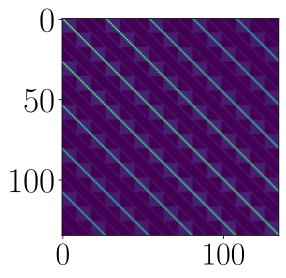

In [119]:
# build the kernel

def k_SEK(x, x_, s=1, l=2):
    return(s*np.exp(-(x-x_)**2 / (2*l**2)))

def k_RQ(x, x_, s=1, l=10, a=0.1):
    return(s**2 * (1 + (x-x_)**2/(2*a*l**2)))**(-a)

def k_dirac_soft(x, x_):
    if x == x_:
        return(1)
    else:
        return(0.1)

n = len(X)
K_XX = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        t_i = X[i,0]
        c_i = X[i,1]
        p_i = X[i,2]
        t_j = X[j,0]
        c_j = X[j,1]
        p_j = X[j,2]
        #K_XX[i, j] = k_SEK(t_i, t_j) * k_dirac_soft(c_i, c_j) * k_dirac_soft(p_i, p_j)
        K_XX[i, j] = k_RQ(t_i, t_j) * k_dirac_soft(c_i, c_j) * k_dirac_soft(p_i, p_j)
        
print(np.shape(K_XX))
K_XX[:10,:10]

plt.imshow(K_XX)
plt.show()

In [120]:
# prep y data

#prior for the dirichlet
alpha_0 = 1

t0 = time.time()
Y_mu = np.array([Dirichlet_bridge_mu(np.array(row[1].values) + alpha_0) for row in medium_df.iterrows()])
t1 = time.time()
print("mu transformation time: ", t1 - t0)
Y_mu = Y_mu.reshape(-1)

#print(Y_mu)

t0 = time.time()
Y_Sigma = [Dirichlet_bridge_Sigma(np.array(row[1].values) + alpha_0) for row in medium_df.iterrows()]
t1 = time.time()
print("Sigma transformation time: ", t1 - t0)

Y_Sigma_block = np.zeros((n,n))
idx = 0
for S in Y_Sigma:
    Y_Sigma_block[idx:idx+n_parties, idx:idx+n_parties] = S
    idx += n_parties

mu transformation time:  0.005732297897338867
Sigma transformation time:  0.009808063507080078


In [121]:
# compute the equations for the GP

from numpy.random import randn, multivariate_normal
from numpy.linalg import cholesky, solve
from scipy.linalg import cho_solve, cho_factor
import time

G_ = K_XX + Y_Sigma_block
t0 = time.time()
G = cho_factor(G_)
t1 = time.time()
print("time for cho factor: ", t1 - t0)

time for cho factor:  0.0008499622344970703


In [122]:
#make predictions for all years in between the elections

T_x = np.arange(2002, 2017+1)
P_x = np.arange(1,n_parties + 1)
C_x = np.arange(1,n_regions + 1)

x = np.zeros((len(T_x)*len(C_x)*len(P_x), 3))
print(np.shape(x))
idx = 0
for t in T_x:
    for c in C_x:
        for p in P_x:
            x[idx] = [t, c, p]
            idx += 1

n_ = len(x)
K_xX = np.zeros((n_, n))
for i in range(n_):
    for j in range(n):
        t_i = x[i,0]
        c_i = x[i,1]
        p_i = x[i,2]
        t_j = X[j,0]
        c_j = X[j,1]
        p_j = X[j,2]
        #K_xX[i, j] = k_SEK(t_i, t_j) * k_dirac_soft(c_i, c_j) * k_dirac_soft(p_i, p_j)
        K_xX[i, j] = k_RQ(t_i, t_j) * k_dirac_soft(c_i, c_j) * k_dirac_soft(p_i, p_j)
        
print(np.shape(K_xX))

K_xx = np.zeros((n_, n_))
for i in range(n_):
    for j in range(n_):
        t_i = x[i,0]
        c_i = x[i,1]
        p_i = x[i,2]
        t_j = x[j,0]
        c_j = x[j,1]
        p_j = x[j,2]
        #K_xx[i, j] = k_SEK(t_i, t_j) * k_dirac_soft(c_i, c_j) * k_dirac_soft(p_i, p_j)
        K_xx[i, j] = k_RQ(t_i, t_j) * k_dirac_soft(c_i, c_j) * k_dirac_soft(p_i, p_j)
        
print(np.shape(K_xx))

(432, 3)
(432, 135)
(432, 432)


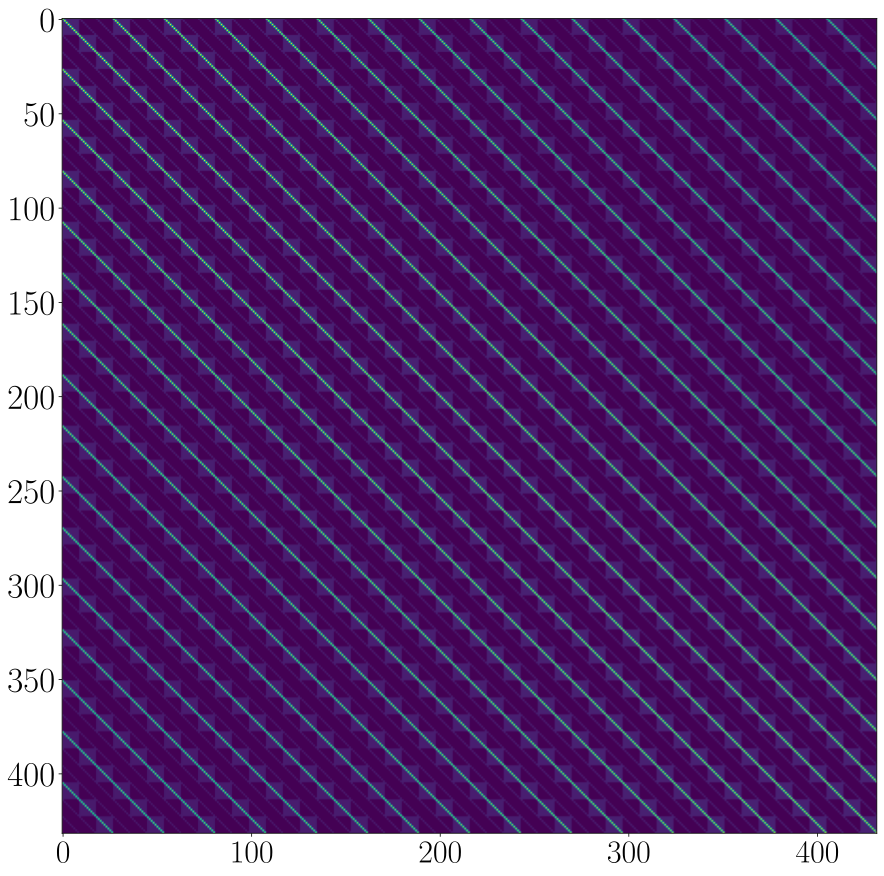

In [123]:
plt.figure(figsize=(15, 15))
plt.imshow(K_xx)
plt.show();

In [124]:
# do some inference 
t0 = time.time()
A = cho_solve(G, K_xX.T).T
t1 = time.time()
print("cho solve: ", t1-t0)

out = {}

# # posterior p(f_x|Y) = N(f_x,mpost,vpost)
t0 = time.time()
out["mpost"] = A @ Y_mu #m(x) + A @ (Y - mX)  # mean
t1 = time.time()
print("matrix multiplication with mu: ", t1-t0)
print(np.shape(out['mpost']))

t0 = time.time()
out["vpost"] = K_xx - A @ K_xX.T  # covariance
t1 = time.time()
print("Computing Kernel for prediction: ", t1-t0)
print(np.shape(out['vpost']))

n_GP_samples = 10000

#This makes the kernel die because it's too large
out["spost"] = multivariate_normal(
    out["mpost"].flatten(), out["vpost"], size=n_GP_samples
)

cho solve:  0.0012881755828857422
matrix multiplication with mu:  0.00010752677917480469
(432,)
Computing Kernel for prediction:  0.0018568038940429688
(432, 432)


In [125]:
Tübingen_pred = out["mpost"]
Tübingen_pred_v = np.diag(out["vpost"])
print(np.shape(Tübingen_pred))
print(np.shape(Tübingen_pred_v))

Tübingen_pred = Tübingen_pred.reshape((-1, n_regions*n_parties))
Tübingen_pred_v = Tübingen_pred_v.reshape((-1, n_regions*n_parties))

Tübingen_pred_Markt = Tübingen_pred[:, :n_parties]
Tübingen_pred_Wanne = Tübingen_pred[:, n_parties:2*n_parties]
Tübingen_pred_Franz = Tübingen_pred[:, 2*n_parties:3*n_parties]

Tübingen_pred_Markt_v = Tübingen_pred_v[:, :n_parties]
Tübingen_pred_Wanne_v = Tübingen_pred_v[:, n_parties:2*n_parties]
Tübingen_pred_Franz_v = Tübingen_pred_v[:, 2*n_parties:3*n_parties]

print(np.shape(Tübingen_pred_Markt))
print(np.shape(Tübingen_pred_Markt_v))

(432,)
(432,)
(16, 9)
(16, 9)


In [126]:
# Bridge back to Dirichlet land via softmax

sm_results_Markt = softmax_batch(Tübingen_pred_Markt)
sm_cumulative_Markt = np.cumsum(sm_results_Markt, 1)

sm_results_Wanne = softmax_batch(Tübingen_pred_Wanne)
sm_cumulative_Wanne = np.cumsum(sm_results_Wanne, 1)

sm_results_Franz = softmax_batch(Tübingen_pred_Franz)
sm_cumulative_Franz = np.cumsum(sm_results_Franz, 1)


In [127]:
#parties = ['CDU/CSU', 'SPD', 'FDP', 'GRÜNE', 'DIE LINKE', 'AfD', 'PIRATEN', 'DIE PARTEI', 'OTHER']

party_colors = {
    'CDU/CSU':'black',
    'SPD':'red',
    'FDP':'yellow',
    'GRÜNE':'green',
    'DIE LINKE':'magenta',
    'AfD':'deepskyblue',
    'PIRATEN':'purple',
    'DIE PARTEI':'firebrick',
    'OTHER':'grey'
}

In [128]:
def plot_results(sm_result, results_v, filename,  save=False, x=T_x, legend=True):
    
    plt.rcParams["font.weight"] = "normal"
    plt.rcParams["axes.labelweight"] = "normal"
    plt.rcParams['xtick.labelsize'] = 20
    plt.rcParams['ytick.labelsize'] = 20
    plt.rcParams["font.family"] = "serif"
    plt.rcParams["font.serif"] = "Times New Roman"
    legend_size=25
    #xlabel_size=25
    #ylabel_size=25
    #title_size=25
    lw_size=3

    plt.figure(figsize=(10, 5))
    plt.xlim((np.min(T_x), np.max(T_x)))
    for i in range(n_parties):
        plt.plot(x, sm_result[:, i], label=parties[i], color=party_colors[parties[i]], lw=3)
        plt.plot(x, sm_result[:, i] + results_v[:, i], color=party_colors[parties[i]], lw=1)
        plt.plot(x, sm_result[:, i] - results_v[:, i], color=party_colors[parties[i]], lw=1)

    if legend:
        plt.legend(prop={'size': legend_size})    
    plt.tight_layout()
    if save:
        plt.savefig(filename)
    plt.show();

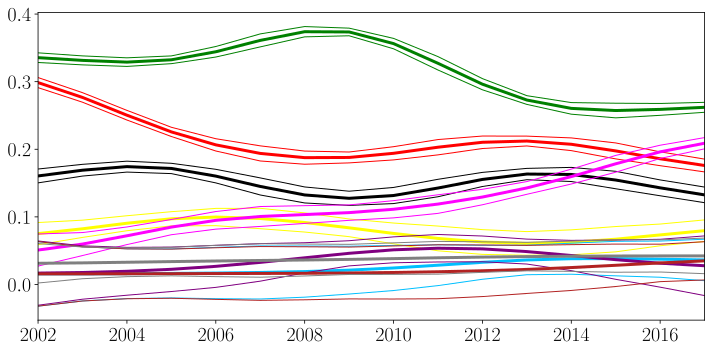

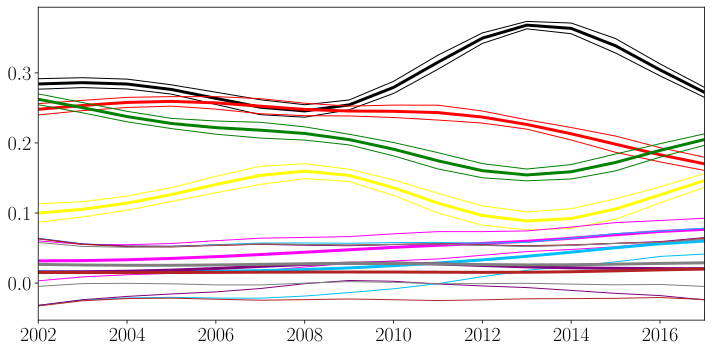

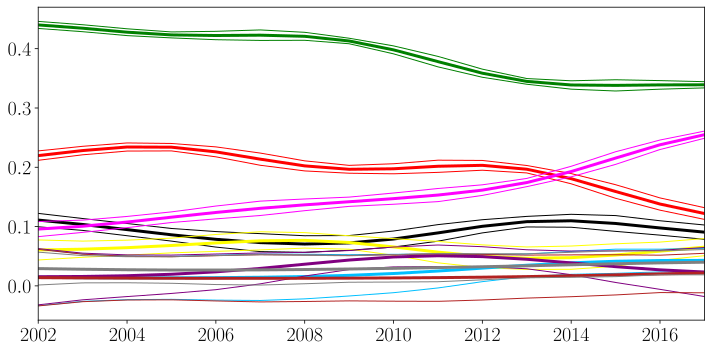

In [129]:
sm_results = [sm_results_Markt, sm_results_Wanne, sm_results_Franz]

results_v = [Tübingen_pred_Markt_v, Tübingen_pred_Wanne_v, Tübingen_pred_Franz_v]

filenames = ['sm_Markt.pdf', 'sm_Wanne.pdf', 'sm_Franz.pdf']

for j in range(len(sm_results)):
    
    r = sm_results[j]
    v = results_v[j]
    plot_results(r, v, filename=filenames[j], save=False, legend=False)

In [130]:

def plot_cum_results(sm_results_cum, results_v, x=T_x, save=False, filename='test.pdf', legend=False):

    plt.rc('text', usetex=True)
    plt.rc('xtick', labelsize=32)
    plt.rc('ytick', labelsize=35)
    plt.rc('axes', labelsize=35)
    legend_size=28
    #xlabel_size=25
    #ylabel_size=25
    #title_size=25
    lw_size=3
    
    fig = plt.figure(figsize=(10, 5))
    plt.ylim((0.0, 1.00))
    plt.xlim((np.min(T_x), np.max(T_x)))
    for i in range(n_parties):
        c = party_colors[parties[i]]
        
        plt.plot(x, sm_results_cum[:, i], label=parties[i], color=c)
        y2 = sm_results_cum[:, i].astype('float')
        if i == 0:
            plt.fill_between(x, y1=np.zeros(len(sm_results_cum)), y2=y2, color=c)
        else:
            y1 = sm_results_cum[:, i-1].astype('float')
            plt.fill_between(x, y1=y1, y2=y2, color=party_colors[parties[i]])
    
    if legend:
        leg = plt.legend(prop={'size': legend_size}) 
        # set the linewidth of each legend object
        for legobj in leg.legendHandles:
            legobj.set_linewidth(15.0)
        
    fig.tight_layout()
    if save:
        plt.savefig(filename)
        plt.show();

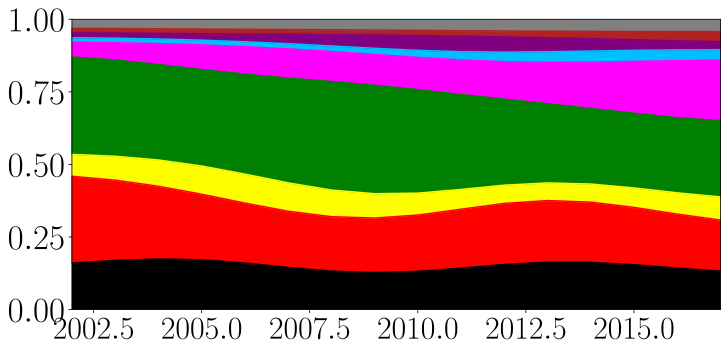

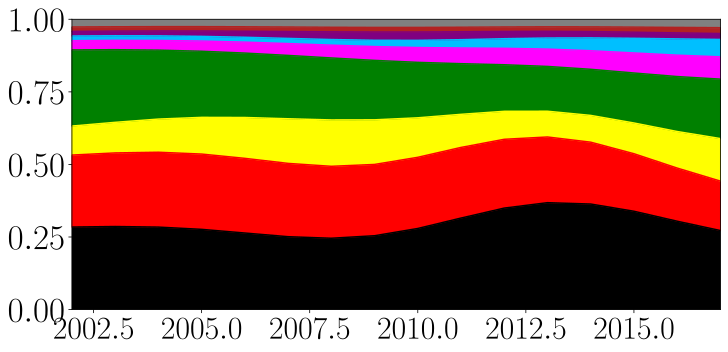

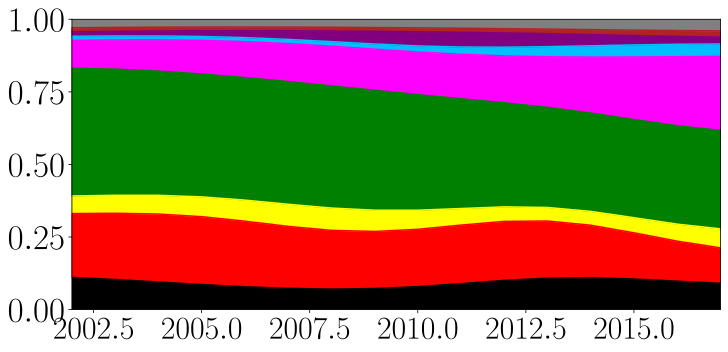

In [131]:
sm_cum_results = [sm_cumulative_Markt, sm_cumulative_Wanne, sm_cumulative_Franz]

filenames = ['sm_Markt_cum.pdf', 'sm_Wanne_cum.pdf', 'sm_Franz_cum.pdf']

for i in range(len(sm_cum_results)):
    
    r = sm_cum_results[i]
    v = results_v[i]
    plot_cum_results(r, v, save=False, filename=filenames[i], legend=False)

In [132]:
# data prep for the GP+LM samples

election_GP_samples = out["spost"]
print(election_GP_samples.shape)

election_GP_samples = election_GP_samples.reshape((n_GP_samples,-1, n_regions*n_parties))
print(election_GP_samples.shape)

Tübingen_pred_Markt_GP_s = election_GP_samples[:, :, :n_parties]
Tübingen_pred_Wanne_GP_s = election_GP_samples[:, :, n_parties:2*n_parties]
Tübingen_pred_Franz_GP_s = election_GP_samples[:, :, 2*n_parties:3*n_parties]

sm_results_Markt_GP_s = np.array([softmax_batch(s_i) for s_i in Tübingen_pred_Markt_GP_s]) 
sm_cumulative_Markt_GP_s = np.cumsum(sm_results_Markt_GP_s, 2)

sm_results_Wanne_GP_s = np.array([softmax_batch(s_i) for s_i in Tübingen_pred_Wanne_GP_s]) 
sm_cumulative_Wanne_GP_s = np.cumsum(sm_results_Wanne_GP_s, 2)

sm_results_Franz_GP_s = np.array([softmax_batch(s_i) for s_i in Tübingen_pred_Franz_GP_s]) 
sm_cumulative_Franz_GP_s = np.cumsum(sm_results_Franz_GP_s, 2)

print(np.shape(sm_results_Markt_GP_s))
print(np.shape(sm_cumulative_Markt_GP_s))

(10000, 432)
(10000, 16, 27)
(10000, 16, 9)
(10000, 16, 9)


In [133]:
# create plot for samples instead of color strengths


def plot_samples_cum(samples_cum, sm_results_cum, save=False, filename='test.pdf', x=T_x, legend=False):
    
    plt.rc('text', usetex=True)
    plt.rc('xtick', labelsize=32)
    plt.rc('ytick', labelsize=35)
    plt.rc('axes', labelsize=35)
    legend_size=28
    #xlabel_size=25
    #ylabel_size=25
    #title_size=25
    lw_size=3
    
    fig = plt.figure(figsize=(10, 5))
    plt.ylim((0.0, 1.00))
    plt.xlim((np.min(T_x), np.max(T_x)))
    
    #plot the means and fill between
    alpha_fill = 0.4
    alpha_samples = 0.6
    
    #"""
    for i in range(n_parties):
        c = party_colors[parties[i]]
        
        plt.plot(x, sm_results_cum[:, i], label=parties[i], color=c)
        y2 = sm_results_cum[:, i].astype('float')
        if i == 0:
            plt.fill_between(x, y1=np.zeros(len(sm_results_cum)), y2=y2, color=c, alpha=alpha_fill)
        else:
            y1 = sm_results_cum[:, i-1].astype('float')
            plt.fill_between(x, y1=y1, y2=y2, color=c, alpha=alpha_fill)
    #"""
    
    #plot all samples
    for s in samples_cum:
        
        for i in range(n_parties):
            c = party_colors[parties[i]]
            
            plt.plot(x, s[:, i], label=parties[i], color=c, alpha=alpha_samples)
            
            """
            y2 = s[:, i].astype('float')
            if i == 0:
                plt.fill_between(x, y1=np.zeros(len(s)), y2=y2, color=c, alpha=alpha_fill)
            else:
                y1 = s[:, i-1].astype('float')
                plt.fill_between(x, y1=y1, y2=y2, color=c, alpha=alpha_fill)
            """    
    
    
    if legend:
        leg = plt.legend(prop={'size': legend_size}) 
        # set the linewidth of each legend object
        for legobj in leg.legendHandles:
            legobj.set_linewidth(15.0)
        
    fig.tight_layout()
    if save:
        plt.savefig(filename)
        plt.show();
        

In [134]:
# plot it

#plot_samples_cum(sm_cumulative_Markt_GP_s, sm_cumulative_Markt, save=False, filename='elections_GP_samples.pdf', legend=False)

In [135]:
import matplotlib.colors as mcolors
from matplotlib.patches import Polygon

def plot_cum_results2(sm_results_cum, results_v, x=T_x, save=False, filename='test.pdf', legend=True):

    plt.rc('text', usetex=True)
    plt.rc('xtick', labelsize=32)
    plt.rc('ytick', labelsize=35)
    plt.rc('axes', labelsize=35)
    legend_size=28
    #xlabel_size=25
    #ylabel_size=25
    #title_size=25
    lw_size=3
    
    plt.figure(figsize=(10, 5))
    plt.ylim((0.0, 1.00))
    lb = 0
    r_prev = np.zeros(x.max() - x.min()+1)
    
    v_min, v_max = results_v.min(), results_v.max()
    for i in range(n_parties):
        
        c = party_colors[parties[i]]
        r = sm_results_cum[:,i].astype('float')
        n = len(r)
        v = results_v[:, i].astype('float')
        #v_min, v_max = v.min(), v.max()
        #c = mc.to_rgba_array(c).reshape(-1,4)
        #c_a = np.tile(c,(n,1)).reshape(-1,4)
        #c_a[:, -1] = v
        #c_a = [tuple(x.reshape(-1)) for x in c_a]
        #print(c_a)
        
        #ax = plt.gca()
        y_min, y_max = r.min(), r.max()
        x_min, x_max = x.min(), x.max()
        
        ax = plt.gca()
        line, = ax.plot(x, r, color=c, label = parties[i])
            
        zorder = line.get_zorder()
        
        z = np.empty((x_max - x_min+1, 1, 4), dtype=float)
        c_norm = 1/v * v_min
        rgb = mcolors.colorConverter.to_rgb(c)
        z[:,:,:3] = rgb
        z[:,:,-1] = c_norm.reshape(-1,1)
        z = z.reshape(1, -1, 4)
        
        im = ax.imshow(z, aspect='auto', extent=[x_min, x_max, lb, y_max], origin='lower', zorder=zorder)
        
        xy = np.column_stack([x, r])
        xy_prev = np.column_stack([x, r_prev])[::-1]
        #print(xy_prev)
        xy = np.vstack([[x_min, lb], xy, [x_max, lb], xy_prev])
        #xy = np.vstack([[xmin, ymin], xy, [xmax, ymin] , [xmin, ymin]])
        clip_path = Polygon(xy, facecolor='none', edgecolor='none', closed=True)
        ax.add_patch(clip_path)
        im.set_clip_path(clip_path)
        
        lb = y_min
        r_prev = r
    
    if legend:
        plt.legend(prop={'size': legend_size})        

    plt.tight_layout()
    if save:
        plt.savefig(filename)
        plt.show();

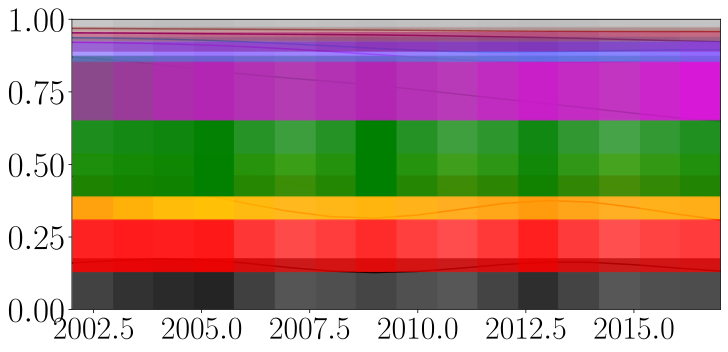

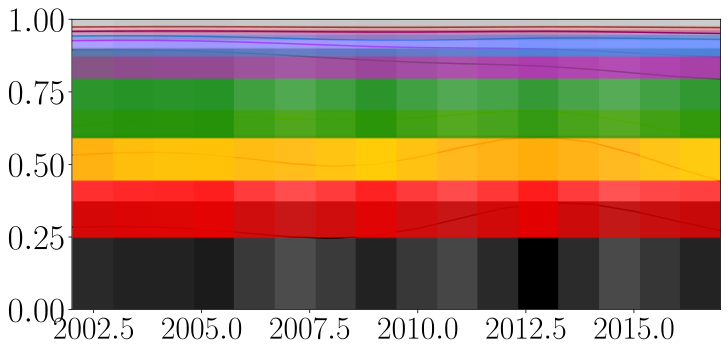

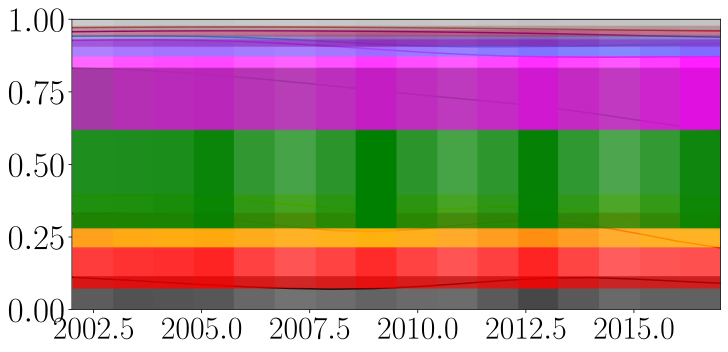

In [136]:
sm_cum_results = [sm_cumulative_Markt, sm_cumulative_Wanne, sm_cumulative_Franz]

filenames2 = ['sm_Markt_cum.pdf', 'sm_Wanne_cum.pdf', 'sm_Franz_cum.pdf']

for i in range(len(sm_cum_results)):
    
    r = sm_cum_results[i]
    v = np.sqrt(results_v[i])
    plot_cum_results2(r, v, save=False, filename=filenames2[i], legend=False)
    

In [137]:
#TODO add other plots

# Compare this to elliptical slice sampling

In [138]:
#
# Elliptical slice sampling
#
import math
def elliptical_slice(initial_theta,prior,lnpdf,pdf_params=(),
                     cur_lnpdf=None,angle_range=None):
    """
    NAME:
       elliptical_slice
    PURPOSE:
       Markov chain update for a distribution with a Gaussian "prior" factored out
    INPUT:
       initial_theta - initial vector
       prior - cholesky decomposition of the covariance matrix 
               (like what numpy.linalg.cholesky returns), 
               or a sample from the prior
       lnpdf - function evaluating the log of the pdf to be sampled
       pdf_params= parameters to pass to the pdf
       cur_lnpdf= value of lnpdf at initial_theta (optional)
       angle_range= Default 0: explore whole ellipse with break point at
                    first rejection. Set in (0,2*pi] to explore a bracket of
                    the specified width centred uniformly at random.
    OUTPUT:
       new_theta, new_lnpdf
    HISTORY:
       Originally written in matlab by Iain Murray (http://homepages.inf.ed.ac.uk/imurray2/pub/10ess/elliptical_slice.m)
       2012-02-24 - Written - Bovy (IAS)
    """
    D= len(initial_theta)
    if cur_lnpdf is None:
        cur_lnpdf= lnpdf(initial_theta,*pdf_params)

    # Set up the ellipse and the slice threshold
    if len(prior.shape) == 1: #prior = prior sample
        nu= prior
        print("first condition is True")
    else: #prior = cholesky decomp
        if not prior.shape[0] == D or not prior.shape[1] == D:
            raise IOError("Prior must be given by a D-element sample or DxD chol(Sigma)")
        nu= np.dot(prior,np.random.normal(size=D))
    hh = math.log(np.random.uniform()) + cur_lnpdf

    # Set up a bracket of angles and pick a first proposal.
    # "phi = (theta'-theta)" is a change in angle.
    if angle_range is None or angle_range == 0.:
        # Bracket whole ellipse with both edges at first proposed point
        phi= np.random.uniform()*2.*math.pi
        phi_min= phi-2.*math.pi
        phi_max= phi
    else:
        # Randomly center bracket on current point
        phi_min= -angle_range*np.random.uniform()
        phi_max= phi_min + angle_range
        phi= np.random.uniform()*(phi_max-phi_min)+phi_min

    #print("nu: ", np.shape(nu))
    #print("nu*math.sin(phi): ", np.shape(nu*math.sin(phi)))
    #print("initial_theta*math.cos(phi): ", np.shape(initial_theta*math.cos(phi)))
        
    # Slice sampling loop
    while True:
        # Compute xx for proposed angle difference and check if it's on the slice
        xx_prop = (initial_theta*math.cos(phi)).reshape(-1) + (nu*math.sin(phi)).reshape(-1)
        #print("xx_prop: ", np.shape(xx_prop))
        cur_lnpdf = lnpdf(xx_prop,*pdf_params)
        if cur_lnpdf > hh:
            # New point is on slice, ** EXIT LOOP **
            break
        # Shrink slice to rejected point
        if phi > 0:
            phi_max = phi
        elif phi < 0:
            phi_min = phi
        else:
            raise RuntimeError('BUG DETECTED: Shrunk to current position and still not acceptable.')
        # Propose new angle difference
        phi = np.random.uniform()*(phi_max - phi_min) + phi_min
    return (xx_prop,cur_lnpdf)

In [139]:
# apply the ESS algorithm to get samples
from scipy.special import logsumexp

y_values = medium_df.reset_index(drop=True).values

# define the log-likelihood as log prod_t prod_c prod_p softmax(f(t,c))[p]^y[t,c,p]
# we can pull the log in to get sums and logsumexps for the softmax

def log_likelihood(x, y=y_values, n_parties=n_parties):
    #TODO: what is x, y, n_parties
    
    #reshape the vector such that we have p columns for the parties and every row is one [t,c]
    x_ = x.reshape(-1, n_parties)
    y_ = y.reshape(-1, n_parties)
    
    #apply the log softmax to all rows in parallel
    x_sm = x_ - logsumexp(x_, axis=1).reshape(-1, 1)
    
    #take all softmax points to the power of the corresponding vote count y
    x_sm_y = x_sm * y_
    
    #return the sum over everything as the log-likelihood
    return(np.sum(x_sm_y))

n_samples = 10000
burn_in = 1000

"""
# draw the first f_x from our prior GP with mean 0 and Cov k_XX
f_x = multivariate_normal(
    np.zeros(n), K_XX, size=1
).T
"""

# 'cheat' by choosing the init from the true observed probabilities
y_norm = np.array(y_values/y_values.sum(1).reshape(-1,1), dtype=float) + 10e-8 # <- to prevent the 0s
log_ = np.log(y_norm)
f_x = log_ - log_.sum(1).reshape(-1,1)
f_x = f_x.reshape(-1)

L = np.linalg.cholesky(G_)

post_samples_1 = np.zeros((1, n))
post_samples_2 = np.zeros((2, n))
post_samples_3 = np.zeros((3, n))
post_samples_4 = np.zeros((4, n))
post_samples_5 = np.zeros((5, n))
post_samples_10 = np.zeros((10, n))
post_samples_50 = np.zeros((50, n))
post_samples_100 = np.zeros((100, n))
post_samples_500 = np.zeros((500, n))
post_samples_1k = np.zeros((1000, n))
post_samples_2k = np.zeros((2000, n))
post_samples_3k = np.zeros((3000, n))
post_samples_4k = np.zeros((4000, n))
post_samples_5k = np.zeros((5000, n))
post_samples_6k = np.zeros((6000, n))
post_samples_7k = np.zeros((7000, n))
post_samples_8k = np.zeros((8000, n))
post_samples_9k = np.zeros((9000, n))
post_samples_10k = np.zeros((10000, n))

print("L: ", np.shape(L))

t0 = time.time()
# get many samples with ESS
for i in range(-burn_in, n_samples):
    #sample one sample
    f_x, ll = elliptical_slice(initial_theta=f_x, prior=L, lnpdf=log_likelihood) 
    if i % 50 == 0: 
            print("iteration: ", i)
            print("log-likelihood: ", ll)
    if i >= 0:
        post_samples_10k[i] = f_x
        if i < 1: post_samples_1[i] = f_x
        if i < 2: post_samples_2[i] = f_x
        if i < 3: post_samples_3[i] = f_x
        if i < 4: post_samples_4[i] = f_x
        if i < 5: post_samples_5[i] = f_x
        if i < 10: post_samples_10[i] = f_x
        if i < 50: post_samples_50[i] = f_x
        if i < 100: post_samples_100[i] = f_x
        if i < 500: post_samples_500[i] = f_x
        if i < 1000: post_samples_1k[i] = f_x
        if i < 2000: post_samples_2k[i] = f_x
        if i < 3000: post_samples_3k[i] = f_x
        if i < 4000: post_samples_4k[i] = f_x
        if i < 5000: post_samples_5k[i] = f_x
        if i < 6000: post_samples_6k[i] = f_x
        if i < 7000: post_samples_7k[i] = f_x
        if i < 8000: post_samples_8k[i] = f_x
        if i < 9000: post_samples_9k[i] = f_x
        
t1 = time.time()
print("time to take samples: ", t1-t0)



L:  (135, 135)
iteration:  -1000
log-likelihood:  -14178.97830745319
iteration:  -950
log-likelihood:  -14191.49187505205
iteration:  -900
log-likelihood:  -14200.747114055084
iteration:  -850
log-likelihood:  -14193.156808648357
iteration:  -800
log-likelihood:  -14193.105263981684
iteration:  -750
log-likelihood:  -14191.302279931948
iteration:  -700
log-likelihood:  -14199.0627785717
iteration:  -650
log-likelihood:  -14204.700809048776
iteration:  -600
log-likelihood:  -14205.403155965661
iteration:  -550
log-likelihood:  -14213.754768936315
iteration:  -500
log-likelihood:  -14209.325972508155
iteration:  -450
log-likelihood:  -14210.81525759794
iteration:  -400
log-likelihood:  -14210.97825473739
iteration:  -350
log-likelihood:  -14209.508484448012
iteration:  -300
log-likelihood:  -14214.10336292542
iteration:  -250
log-likelihood:  -14208.399530785258
iteration:  -200
log-likelihood:  -14203.482962615564
iteration:  -150
log-likelihood:  -14200.874892995882
iteration:  -100
lo

iteration:  6800
log-likelihood:  -14256.368951443132
iteration:  6850
log-likelihood:  -14258.123652372893
iteration:  6900
log-likelihood:  -14251.599489201268
iteration:  6950
log-likelihood:  -14262.796171913675
iteration:  7000
log-likelihood:  -14260.920577335784
iteration:  7050
log-likelihood:  -14258.114874627687
iteration:  7100
log-likelihood:  -14259.860178926241
iteration:  7150
log-likelihood:  -14257.747651887234
iteration:  7200
log-likelihood:  -14257.383146222748
iteration:  7250
log-likelihood:  -14256.589442031953
iteration:  7300
log-likelihood:  -14259.948090107133
iteration:  7350
log-likelihood:  -14258.71416434621
iteration:  7400
log-likelihood:  -14256.703756961566
iteration:  7450
log-likelihood:  -14254.847166067784
iteration:  7500
log-likelihood:  -14265.575488750355
iteration:  7550
log-likelihood:  -14259.215844909551
iteration:  7600
log-likelihood:  -14258.327467657513
iteration:  7650
log-likelihood:  -14256.033988339335
iteration:  7700
log-likeliho

In [140]:
def pred_samples_sm_cum(samples, all=False):
    
    
    if all: 
        pred_samples_sm_cum_all = []
        
        for s in samples:
            
            s = s.reshape((-1, n_parties))
            sm_s = softmax_batch(s)
            sm_s_cum = np.cumsum(sm_s, 1)
        
            pred_samples_sm_cum_all.append(sm_s_cum)
        
        return(np.array(pred_samples_sm_cum_all))
    
    else: 
        
        pred_samples_Markt_sm_cum = []
        pred_samples_Wanne_sm_cum = []
        pred_samples_Franz_sm_cum = []
        
        for s in samples:

            s = s.reshape((-1, n_regions*n_parties))

            sample_pred_Markt = s[:, :n_parties]
            sample_pred_Wanne = s[:, n_parties:2*n_parties]
            sample_pred_Franz = s[:, 2*n_parties:3*n_parties]

            sm_s_results_Markt = softmax_batch(sample_pred_Markt)
            sm_s_cumulative_Markt = np.cumsum(sm_s_results_Markt, 1)

            sm_s_results_Wanne = softmax_batch(sample_pred_Wanne)
            sm_s_cumulative_Wanne = np.cumsum(sm_s_results_Wanne, 1)

            sm_s_results_Franz = softmax_batch(sample_pred_Franz)
            sm_s_cumulative_Franz = np.cumsum(sm_s_results_Franz, 1)

            pred_samples_Markt_sm_cum.append(sm_s_cumulative_Markt)
            pred_samples_Wanne_sm_cum.append(sm_s_cumulative_Wanne)
            pred_samples_Franz_sm_cum.append(sm_s_cumulative_Franz)

        pred_samples_Markt_sm_cum = np.array(pred_samples_Markt_sm_cum)
        pred_samples_Wanne_sm_cum = np.array(pred_samples_Wanne_sm_cum)
        pred_samples_Franz_sm_cum = np.array(pred_samples_Franz_sm_cum)

        return(pred_samples_Markt_sm_cum,
               pred_samples_Wanne_sm_cum,
               pred_samples_Franz_sm_cum)
    
def pred_samples_sm(samples, all=False):
    
    
    if all: 
        pred_samples_sm_all = []
        
        for s in samples:
            
            s = s.reshape((-1, n_parties))
            sm_s = softmax_batch(s)
        
            pred_samples_sm_all.append(sm_s)
        
        return(np.array(pred_samples_sm_all))
    
    else: 
        
        pred_samples_Markt_sm = []
        pred_samples_Wanne_sm = []
        pred_samples_Franz_sm = []
        
        for s in samples:

            s = s.reshape((-1, n_regions*n_parties))

            sample_pred_Markt = s[:, :n_parties]
            sample_pred_Wanne = s[:, n_parties:2*n_parties]
            sample_pred_Franz = s[:, 2*n_parties:3*n_parties]

            sm_s_results_Markt = softmax_batch(sample_pred_Markt)

            sm_s_results_Wanne = softmax_batch(sample_pred_Wanne)

            sm_s_results_Franz = softmax_batch(sample_pred_Franz)

            pred_samples_Markt_sm.append(sm_s_results_Markt)
            pred_samples_Wanne_sm.append(sm_s_results_Wanne)
            pred_samples_Franz_sm.append(sm_s_results_Franz)

        pred_samples_Markt_sm = np.array(pred_samples_Markt_sm)
        pred_samples_Wanne_sm = np.array(pred_samples_Wanne_sm)
        pred_samples_Franz_sm = np.array(pred_samples_Franz_sm)

        return(pred_samples_Markt_sm,
               pred_samples_Wanne_sm,
               pred_samples_Franz_sm)

In [141]:
# project the samples into the prediction space
ESS_pred_10k = np.array([A @ S for S in post_samples_10k]) #currently only 500 for testing
ESS_pred_10k_sm_cum = pred_samples_sm_cum(ESS_pred_10k, all=True)
ESS_pred_10k_Markt_sm_cum, ESS_pred_10k_Wanne_sm_cum, ESS_pred_10k_Franz_sm_cum = pred_samples_sm_cum(ESS_pred_10k, all=False)
ESS_pred_10k_Markt_sm, ESS_pred_10k_Wanne_sm, ESS_pred_10k_Franz_sm = pred_samples_sm(ESS_pred_10k, all=False)
print(np.shape(ESS_pred_10k_sm_cum))
print(np.shape(ESS_pred_10k_Markt_sm_cum))
print(np.shape(ESS_pred_10k_Markt_sm))

(10000, 48, 9)
(10000, 16, 9)
(10000, 16, 9)


In [142]:
# for all 10k samples draw one sample that from a Gaussian with the sample as mean
# and the Kernel from the top as Covariance matrix

ESS_pred_10k_Gaussian = []
for s in ESS_pred_10k:
    ESS_pred_10k_Gaussian.append(multivariate_normal(s.flatten(), out["vpost"], size=1))
                                 
ESS_pred_10k_Gaussian = np.array(ESS_pred_10k_Gaussian).reshape(np.shape(ESS_pred_10k))
print(np.shape(ESS_pred_10k_Gaussian))

(10000, 432)


In [143]:
ESS_pred_10k_Markt_sm_cum_Gaussian, ESS_pred_10k_Wanne_sm_cum_Gaussian, ESS_pred_10k_Franz_sm_cum_Gaussian = pred_samples_sm_cum(ESS_pred_10k_Gaussian, all=False)
ESS_pred_10k_Markt_sm_Gaussian, ESS_pred_10k_Wanne_sm_Gaussian, ESS_pred_10k_Franz_sm_Gaussian = pred_samples_sm(ESS_pred_10k_Gaussian, all=False)
print(np.shape(ESS_pred_10k_Markt_sm_cum_Gaussian))
print(np.shape(ESS_pred_10k_Markt_sm_Gaussian))

(10000, 16, 9)
(10000, 16, 9)


In [144]:
ESS_pred_Markt = ESS_pred_10k_Markt_sm_cum_Gaussian.mean(0)
ESS_pred_Wanne = ESS_pred_10k_Wanne_sm_cum_Gaussian.mean(0)
ESS_pred_Franz = ESS_pred_10k_Franz_sm_cum_Gaussian.mean(0)

ESS_pred_Markt_std = ESS_pred_10k_Markt_sm_cum_Gaussian.std(0)
ESS_pred_Wanne_std = ESS_pred_10k_Wanne_sm_cum_Gaussian.std(0)
ESS_pred_Franz_std = ESS_pred_10k_Franz_sm_cum_Gaussian.std(0)

#plot_cum_results2(ESS_pred_Markt, ESS_pred_Markt_std, save=False, filename='test', legend=False)
#plot_cum_results2(ESS_pred_Wanne, ESS_pred_Wanne_std, save=False, filename='test', legend=False)
#plot_cum_results2(ESS_pred_Franz, ESS_pred_Franz_std, save=False, filename='test', legend=False)

In [145]:
# plot it

#plot_samples_cum(ESS_pred_10k_Markt_sm_cum, ESS_pred_Markt, save=False, filename='elections_GP_samples.pdf', legend=False)
#plot_samples_cum(ESS_pred_10k_Markt_sm_cum_Gaussian, ESS_pred_Markt, save=False, filename='elections_GP_samples.pdf', legend=False)

In [146]:
print(np.shape(ESS_pred_10k_Markt_sm_cum_Gaussian))
ESS_pred_10k_Markt_sm_cum_Gaussian_2004 = ESS_pred_10k_Markt_sm_cum_Gaussian[:, 2, :]
ESS_pred_10k_Markt_sm_Gaussian_2004 = ESS_pred_10k_Markt_sm_Gaussian[:, 2, :]
print(np.shape(ESS_pred_10k_Markt_sm_cum_Gaussian_2004))

(10000, 16, 9)
(10000, 9)


In [147]:
## invert Laplace Matching and check the result

print(np.shape(out["mpost"]))
print(np.shape(out["vpost"]))

(432,)
(432, 432)


## Compare the predictions of LM with LM+GP-samples and ESS samples

In [148]:
# Make inline plots vector graphics
from IPython.display import set_matplotlib_formats

set_matplotlib_formats("pdf", "svg")

#matplotlib.rc("font", **{"family": "serif", "serif": ["Computer Modern"]})
plt.rcParams["text.usetex"] = True
plt.rcParams["text.latex.preamble"] = r"\usepackage{amsfonts} \usepackage{amsmath}"

In [149]:
mu_pred = out["mpost"].reshape((-1, n_regions*n_parties))

mu_pred_Markt = mu_pred[:, :n_parties]
mu_pred_Wanne = mu_pred[:, n_parties:2*n_parties]
mu_pred_Franz = mu_pred[:, 2*n_parties:3*n_parties]

print(np.shape(mu_pred_Markt))

mu_pred_Markt_2004 = mu_pred_Markt[2, :]
print(np.shape(mu_pred_Markt_2004))

print(out["mpost"][(2*n_regions)*n_parties:(2*n_regions+1)*n_parties])
print(mu_pred_Markt_2004)

Sigma_pred_Markt_2004 = out["vpost"][(2*n_regions)*n_parties:(2*n_regions+1)*n_parties, (2*n_regions)*n_parties:(2*n_regions+1)*n_parties]
print(np.shape(Sigma_pred_Markt_2004))

alphas_pred_2004 = Dirichlet_bridge_alpha(mu=mu_pred_Markt_2004, Sigma=Sigma_pred_Markt_2004)

print(alphas_pred_2004)

(16, 9)
(9,)
[ 1.02308893  1.38531412  0.36813335  1.65819969  0.13882428 -1.37291008
 -1.17049881 -1.38310035 -0.64705112]
[ 1.02308893  1.38531412  0.36813335  1.65819969  0.13882428 -1.37291008
 -1.17049881 -1.38310035 -0.64705112]
(9, 9)
[162.00631877 215.55483661  94.89193101 279.23149958  76.50352658
  22.41073849  23.63726031  22.37779347  41.16834677]


In [150]:
alpha_sum_2004 = alphas_pred_2004.sum()
alpha_0, beta_0 = alphas_pred_2004[0], alpha_sum_2004 - alphas_pred_2004[0]
alpha_1, beta_1 = alphas_pred_2004[1], alpha_sum_2004 - alphas_pred_2004[1]
alpha_2, beta_2 = alphas_pred_2004[2], alpha_sum_2004 - alphas_pred_2004[2]
alpha_3, beta_3 = alphas_pred_2004[3], alpha_sum_2004 - alphas_pred_2004[3]
alpha_4, beta_4 = alphas_pred_2004[4], alpha_sum_2004 - alphas_pred_2004[4]
alpha_5, beta_5 = alphas_pred_2004[5], alpha_sum_2004 - alphas_pred_2004[5]

from scipy.stats import beta

x_beta = np.linspace(0, 1, 1000+1)
beta_func_0 = beta.pdf(x_beta, alpha_0, beta_0)
beta_func_1 = beta.pdf(x_beta, alpha_1, beta_1)
beta_func_2 = beta.pdf(x_beta, alpha_2, beta_2)
beta_func_3 = beta.pdf(x_beta, alpha_3, beta_3)
beta_func_4 = beta.pdf(x_beta, alpha_4, beta_4)
beta_func_5 = beta.pdf(x_beta, alpha_5, beta_5)

(10000, 16, 9)
(10000, 9)


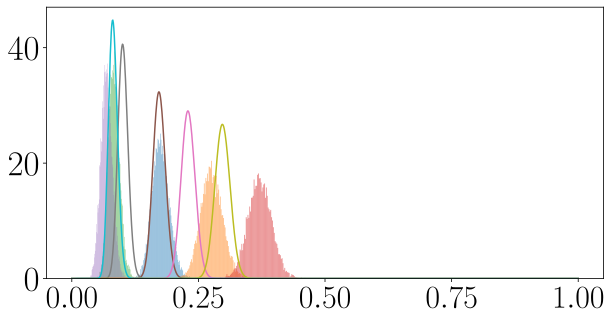

In [151]:
print(np.shape(ESS_pred_10k_Markt_sm_cum_Gaussian))
print(np.shape(ESS_pred_10k_Markt_sm_cum_Gaussian_2004))

plt.figure(figsize=(10, 5))
plt.hist(ESS_pred_10k_Markt_sm_Gaussian_2004[:,0], density=True, alpha=0.5, bins=100)
plt.hist(ESS_pred_10k_Markt_sm_Gaussian_2004[:,1], density=True, alpha=0.5, bins=100)
plt.hist(ESS_pred_10k_Markt_sm_Gaussian_2004[:,2], density=True, alpha=0.5, bins=100)
plt.hist(ESS_pred_10k_Markt_sm_Gaussian_2004[:,3], density=True, alpha=0.5, bins=100)
plt.hist(ESS_pred_10k_Markt_sm_Gaussian_2004[:,4], density=True, alpha=0.5, bins=100)
#plt.hist(ESS_pred_10k_Markt_sm_Gaussian_2004[:,5], density=True, alpha=0.5, bins=100)

plt.plot(x_beta, beta_func_0)
plt.plot(x_beta, beta_func_1)
plt.plot(x_beta, beta_func_2)
plt.plot(x_beta, beta_func_3)
plt.plot(x_beta, beta_func_4)
#plt.plot(x_beta, beta_func_5)

plt.show();

In [152]:
LM_GP_pred_10k_Markt_sm, LM_GP_pred_10k_Wanne_sm, LM_GP_pred_10k_Franz_sm = pred_samples_sm(election_GP_samples, all=False)
print(np.shape(LM_GP_pred_10k_Markt_sm))

(10000, 16, 9)


(9,)
[ 1.01163612  1.63245525  0.2530752   1.74897499 -0.13710224 -1.31794951
 -1.24806928 -1.31910188 -0.62391866]
[ 1.01163612  1.63245525  0.2530752   1.74897499 -0.13710224 -1.31794951
 -1.24806928 -1.31910188 -0.62391866]
(9, 9)
[127.1565355  235.02574934  62.31094372 262.30256     39.76071581
  17.35437378  17.51021201  17.35022767  30.15772277]


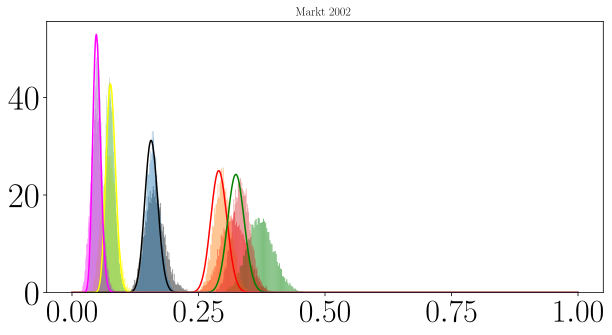

In [153]:
#unit test for 2002 Markt, i.e. the very first entry
ESS_pred_10k_Markt_sm_Gaussian_2002 = ESS_pred_10k_Markt_sm_Gaussian[:, 0, :]
LM_GP_pred_10k_Markt_sm_2002 = LM_GP_pred_10k_Markt_sm[:, 0, :]

mu_pred_Markt_2002 = mu_pred_Markt[0, :]
print(np.shape(mu_pred_Markt_2002))

print(out["mpost"][0:n_parties])
print(mu_pred_Markt_2002)

Sigma_pred_Markt_2002 = out["vpost"][0:n_parties, 0:n_parties]
print(np.shape(Sigma_pred_Markt_2002))

alphas_pred_2002 = Dirichlet_bridge_alpha(mu=mu_pred_Markt_2002, Sigma=Sigma_pred_Markt_2002)

print(alphas_pred_2002)

alpha_sum_2002 = alphas_pred_2002.sum()
alpha_0, beta_0 = alphas_pred_2002[0], alpha_sum_2002 - alphas_pred_2002[0]
alpha_1, beta_1 = alphas_pred_2002[1], alpha_sum_2002 - alphas_pred_2002[1]
alpha_2, beta_2 = alphas_pred_2002[2], alpha_sum_2002 - alphas_pred_2002[2]
alpha_3, beta_3 = alphas_pred_2002[3], alpha_sum_2002 - alphas_pred_2002[3]
alpha_4, beta_4 = alphas_pred_2002[4], alpha_sum_2002 - alphas_pred_2002[4]
alpha_5, beta_5 = alphas_pred_2002[5], alpha_sum_2002 - alphas_pred_2002[5]

from scipy.stats import beta

x_beta = np.linspace(0, 1, 1000+1)
beta_func_0 = beta.pdf(x_beta, alpha_0, beta_0)
beta_func_1 = beta.pdf(x_beta, alpha_1, beta_1)
beta_func_2 = beta.pdf(x_beta, alpha_2, beta_2)
beta_func_3 = beta.pdf(x_beta, alpha_3, beta_3)
beta_func_4 = beta.pdf(x_beta, alpha_4, beta_4)
beta_func_5 = beta.pdf(x_beta, alpha_5, beta_5)

plt.figure(figsize=(10, 5))
plt.hist(ESS_pred_10k_Markt_sm_Gaussian_2002[:,0], density=True, alpha=0.5, bins=100, color=party_colors[parties[0]])
plt.hist(ESS_pred_10k_Markt_sm_Gaussian_2002[:,1], density=True, alpha=0.5, bins=100, color=party_colors[parties[1]])
plt.hist(ESS_pred_10k_Markt_sm_Gaussian_2002[:,2], density=True, alpha=0.5, bins=100, color=party_colors[parties[2]])
plt.hist(ESS_pred_10k_Markt_sm_Gaussian_2002[:,3], density=True, alpha=0.5, bins=100, color=party_colors[parties[3]])
plt.hist(ESS_pred_10k_Markt_sm_Gaussian_2002[:,4], density=True, alpha=0.5, bins=100, color=party_colors[parties[4]])
#plt.hist(ESS_pred_10k_Markt_sm_Gaussian_2004[:,5], density=True, alpha=0.5, bins=100)

plt.hist(LM_GP_pred_10k_Markt_sm_2002[:,0], density=True, alpha=0.5, bins=100)
plt.hist(LM_GP_pred_10k_Markt_sm_2002[:,1], density=True, alpha=0.5, bins=100)
plt.hist(LM_GP_pred_10k_Markt_sm_2002[:,2], density=True, alpha=0.5, bins=100)
plt.hist(LM_GP_pred_10k_Markt_sm_2002[:,3], density=True, alpha=0.5, bins=100)
plt.hist(LM_GP_pred_10k_Markt_sm_2002[:,4], density=True, alpha=0.5, bins=100)

plt.title("Markt 2002")

plt.plot(x_beta, beta_func_0, color=party_colors[parties[0]])
plt.plot(x_beta, beta_func_1, color=party_colors[parties[1]])
plt.plot(x_beta, beta_func_2, color=party_colors[parties[2]])
plt.plot(x_beta, beta_func_3, color=party_colors[parties[3]])
plt.plot(x_beta, beta_func_4, color=party_colors[parties[4]])
#plt.plot(x_beta, beta_func_5)

plt.show();

(9,)
[ 1.0317351   1.52460341  0.31236758  1.70540042 -0.00822668 -1.34907627
 -1.22808359 -1.35251267 -0.6362073 ]
[ 1.0317351   1.52460341  0.31236758  1.70540042 -0.00822668 -1.34907627
 -1.22808359 -1.35251267 -0.6362073 ]
(9, 9)
[151.57460801 234.91377117  81.50352094 276.06299544  56.9017481
  20.64828134  21.10747078  20.63651475  37.5104776 ]


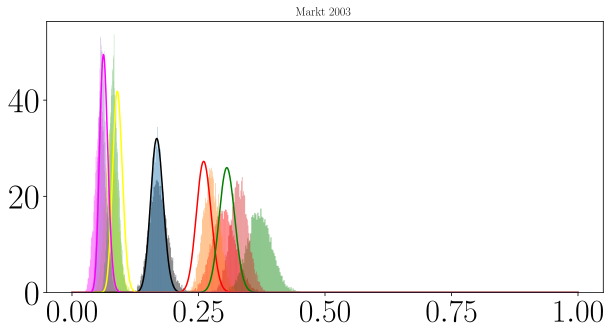

In [154]:
#unit test for 2002 Markt, i.e. the very first entry
ESS_pred_10k_Markt_sm_Gaussian_2003 = ESS_pred_10k_Markt_sm_Gaussian[:, 1, :]
LM_GP_pred_10k_Markt_sm_2003 = LM_GP_pred_10k_Markt_sm[:, 1, :]

mu_pred_Markt_2003 = mu_pred_Markt[1, :]
print(np.shape(mu_pred_Markt_2003))

print(out["mpost"][(1*n_regions)*n_parties:(1*n_regions+1)*n_parties])
print(mu_pred_Markt_2003)

Sigma_pred_Markt_2003 = out["vpost"][(1*n_regions)*n_parties:(1*n_regions+1)*n_parties, (1*n_regions)*n_parties:(1*n_regions+1)*n_parties]
print(np.shape(Sigma_pred_Markt_2003))

alphas_pred_2003 = Dirichlet_bridge_alpha(mu=mu_pred_Markt_2003, Sigma=Sigma_pred_Markt_2003)

print(alphas_pred_2003)

alpha_sum_2003 = alphas_pred_2003.sum()
alpha_0, beta_0 = alphas_pred_2003[0], alpha_sum_2003 - alphas_pred_2003[0]
alpha_1, beta_1 = alphas_pred_2003[1], alpha_sum_2003 - alphas_pred_2003[1]
alpha_2, beta_2 = alphas_pred_2003[2], alpha_sum_2003 - alphas_pred_2003[2]
alpha_3, beta_3 = alphas_pred_2003[3], alpha_sum_2003 - alphas_pred_2003[3]
alpha_4, beta_4 = alphas_pred_2003[4], alpha_sum_2003 - alphas_pred_2003[4]
alpha_5, beta_5 = alphas_pred_2003[5], alpha_sum_2003 - alphas_pred_2003[5]

from scipy.stats import beta

x_beta = np.linspace(0, 1, 1000+1)
beta_func_0 = beta.pdf(x_beta, alpha_0, beta_0)
beta_func_1 = beta.pdf(x_beta, alpha_1, beta_1)
beta_func_2 = beta.pdf(x_beta, alpha_2, beta_2)
beta_func_3 = beta.pdf(x_beta, alpha_3, beta_3)
beta_func_4 = beta.pdf(x_beta, alpha_4, beta_4)
beta_func_5 = beta.pdf(x_beta, alpha_5, beta_5)

plt.figure(figsize=(10, 5))
plt.hist(ESS_pred_10k_Markt_sm_Gaussian_2003[:,0], density=True, alpha=0.5, bins=100, color=party_colors[parties[0]])
plt.hist(ESS_pred_10k_Markt_sm_Gaussian_2003[:,1], density=True, alpha=0.5, bins=100, color=party_colors[parties[1]])
plt.hist(ESS_pred_10k_Markt_sm_Gaussian_2003[:,2], density=True, alpha=0.5, bins=100, color=party_colors[parties[2]])
plt.hist(ESS_pred_10k_Markt_sm_Gaussian_2003[:,3], density=True, alpha=0.5, bins=100, color=party_colors[parties[3]])
plt.hist(ESS_pred_10k_Markt_sm_Gaussian_2003[:,4], density=True, alpha=0.5, bins=100, color=party_colors[parties[4]])
#plt.hist(ESS_pred_10k_Markt_sm_Gaussian_2004[:,5], density=True, alpha=0.5, bins=100)

plt.hist(LM_GP_pred_10k_Markt_sm_2003[:,0], density=True, alpha=0.5, bins=100)
plt.hist(LM_GP_pred_10k_Markt_sm_2003[:,1], density=True, alpha=0.5, bins=100)
plt.hist(LM_GP_pred_10k_Markt_sm_2003[:,2], density=True, alpha=0.5, bins=100)
plt.hist(LM_GP_pred_10k_Markt_sm_2003[:,3], density=True, alpha=0.5, bins=100)
plt.hist(LM_GP_pred_10k_Markt_sm_2003[:,4], density=True, alpha=0.5, bins=100)

plt.title("Markt 2003")

plt.plot(x_beta, beta_func_0, color=party_colors[parties[0]])
plt.plot(x_beta, beta_func_1, color=party_colors[parties[1]])
plt.plot(x_beta, beta_func_2, color=party_colors[parties[2]])
plt.plot(x_beta, beta_func_3, color=party_colors[parties[3]])
plt.plot(x_beta, beta_func_4, color=party_colors[parties[4]])

plt.show();

(9,)
[ 1.02308893  1.38531412  0.36813335  1.65819969  0.13882428 -1.37291008
 -1.17049881 -1.38310035 -0.64705112]
[ 1.02308893  1.38531412  0.36813335  1.65819969  0.13882428 -1.37291008
 -1.17049881 -1.38310035 -0.64705112]
(9, 9)
[162.00631877 215.55483661  94.89193101 279.23149958  76.50352658
  22.41073849  23.63726031  22.37779347  41.16834677]


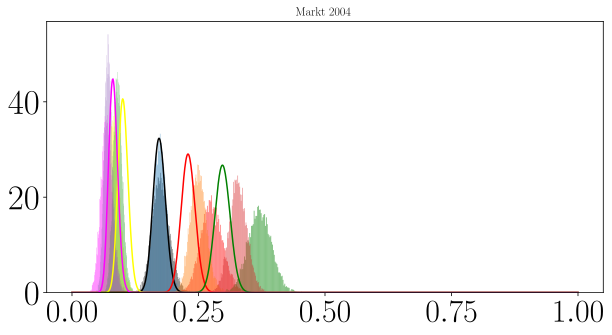

In [155]:
#unit test for 2002 Markt, i.e. the very first entry
ESS_pred_10k_Markt_sm_Gaussian_2004 = ESS_pred_10k_Markt_sm_Gaussian[:, 2, :]
LM_GP_pred_10k_Markt_sm_2004 = LM_GP_pred_10k_Markt_sm[:, 2, :]

mu_pred_Markt_2004 = mu_pred_Markt[2, :]
print(np.shape(mu_pred_Markt_2004))

print(out["mpost"][(2*n_regions)*n_parties:(2*n_regions+1)*n_parties])
print(mu_pred_Markt_2004)

Sigma_pred_Markt_2004 = out["vpost"][(2*n_regions)*n_parties:(2*n_regions+1)*n_parties, (2*n_regions)*n_parties:(2*n_regions+1)*n_parties]
print(np.shape(Sigma_pred_Markt_2004))

alphas_pred_2004 = Dirichlet_bridge_alpha(mu=mu_pred_Markt_2004, Sigma=Sigma_pred_Markt_2004)

print(alphas_pred_2004)

alpha_sum_2004 = alphas_pred_2004.sum()
alpha_0, beta_0 = alphas_pred_2004[0], alpha_sum_2004 - alphas_pred_2004[0]
alpha_1, beta_1 = alphas_pred_2004[1], alpha_sum_2004 - alphas_pred_2004[1]
alpha_2, beta_2 = alphas_pred_2004[2], alpha_sum_2004 - alphas_pred_2004[2]
alpha_3, beta_3 = alphas_pred_2004[3], alpha_sum_2004 - alphas_pred_2004[3]
alpha_4, beta_4 = alphas_pred_2004[4], alpha_sum_2004 - alphas_pred_2004[4]


from scipy.stats import beta

x_beta = np.linspace(0, 1, 1000+1)
beta_func_0 = beta.pdf(x_beta, alpha_0, beta_0)
beta_func_1 = beta.pdf(x_beta, alpha_1, beta_1)
beta_func_2 = beta.pdf(x_beta, alpha_2, beta_2)
beta_func_3 = beta.pdf(x_beta, alpha_3, beta_3)
beta_func_4 = beta.pdf(x_beta, alpha_4, beta_4)

plt.figure(figsize=(10, 5))
plt.hist(ESS_pred_10k_Markt_sm_Gaussian_2004[:,0], density=True, alpha=0.5, bins=100, color=party_colors[parties[0]])
plt.hist(ESS_pred_10k_Markt_sm_Gaussian_2004[:,1], density=True, alpha=0.5, bins=100, color=party_colors[parties[1]])
plt.hist(ESS_pred_10k_Markt_sm_Gaussian_2004[:,2], density=True, alpha=0.5, bins=100, color=party_colors[parties[2]])
plt.hist(ESS_pred_10k_Markt_sm_Gaussian_2004[:,3], density=True, alpha=0.5, bins=100, color=party_colors[parties[3]])
plt.hist(ESS_pred_10k_Markt_sm_Gaussian_2004[:,4], density=True, alpha=0.5, bins=100, color=party_colors[parties[4]])


plt.hist(LM_GP_pred_10k_Markt_sm_2004[:,0], density=True, alpha=0.5, bins=100)
plt.hist(LM_GP_pred_10k_Markt_sm_2004[:,1], density=True, alpha=0.5, bins=100)
plt.hist(LM_GP_pred_10k_Markt_sm_2004[:,2], density=True, alpha=0.5, bins=100)
plt.hist(LM_GP_pred_10k_Markt_sm_2004[:,3], density=True, alpha=0.5, bins=100)
plt.hist(LM_GP_pred_10k_Markt_sm_2004[:,4], density=True, alpha=0.5, bins=100)

plt.title("Markt 2004")

plt.plot(x_beta, beta_func_0, color=party_colors[parties[0]])
plt.plot(x_beta, beta_func_1, color=party_colors[parties[1]])
plt.plot(x_beta, beta_func_2, color=party_colors[parties[2]])
plt.plot(x_beta, beta_func_3, color=party_colors[parties[3]])
plt.plot(x_beta, beta_func_4, color=party_colors[parties[4]])

plt.show();

(9,)
[ 0.97053335  1.24438527  0.40135458  1.6316067   0.2660481  -1.38456151
 -1.06625884 -1.40835049 -0.65475717]
[ 0.97053335  1.24438527  0.40135458  1.6316067   0.2660481  -1.38456151
 -1.06625884 -1.40835049 -0.65475717]
(9, 9)
[166.96156628 208.96809371 100.80813306 303.13102642  90.59607933
  22.74495255  25.62555888  22.66313679  41.51749164]


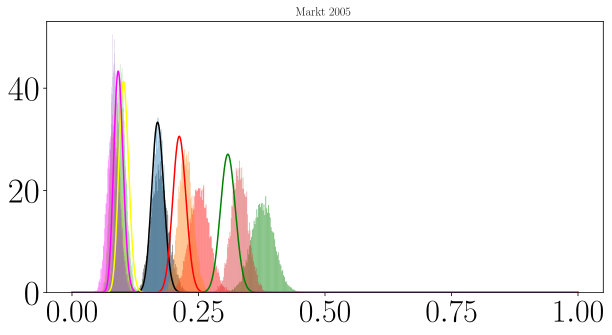

In [156]:
#unit test for 2002 Markt, i.e. the very first entry
ESS_pred_10k_Markt_sm_Gaussian_2005 = ESS_pred_10k_Markt_sm_Gaussian[:, 3, :]
LM_GP_pred_10k_Markt_sm_2005 = LM_GP_pred_10k_Markt_sm[:, 3, :]

mu_pred_Markt_2005 = mu_pred_Markt[3, :]
print(np.shape(mu_pred_Markt_2005))

print(out["mpost"][(3*n_regions)*n_parties:(3*n_regions+1)*n_parties])
print(mu_pred_Markt_2005)

Sigma_pred_Markt_2005 = out["vpost"][(3*n_regions)*n_parties:(3*n_regions+1)*n_parties, (3*n_regions)*n_parties:(3*n_regions+1)*n_parties]
print(np.shape(Sigma_pred_Markt_2005))

alphas_pred_2005 = Dirichlet_bridge_alpha(mu=mu_pred_Markt_2005, Sigma=Sigma_pred_Markt_2005)

print(alphas_pred_2005)

alpha_sum_2005 = alphas_pred_2005.sum()
alpha_0, beta_0 = alphas_pred_2005[0], alpha_sum_2005 - alphas_pred_2005[0]
alpha_1, beta_1 = alphas_pred_2005[1], alpha_sum_2005 - alphas_pred_2005[1]
alpha_2, beta_2 = alphas_pred_2005[2], alpha_sum_2005 - alphas_pred_2005[2]
alpha_3, beta_3 = alphas_pred_2005[3], alpha_sum_2005 - alphas_pred_2005[3]
alpha_4, beta_4 = alphas_pred_2005[4], alpha_sum_2005 - alphas_pred_2005[4]


from scipy.stats import beta

x_beta = np.linspace(0, 1, 1000+1)
beta_func_0 = beta.pdf(x_beta, alpha_0, beta_0)
beta_func_1 = beta.pdf(x_beta, alpha_1, beta_1)
beta_func_2 = beta.pdf(x_beta, alpha_2, beta_2)
beta_func_3 = beta.pdf(x_beta, alpha_3, beta_3)
beta_func_4 = beta.pdf(x_beta, alpha_4, beta_4)

plt.figure(figsize=(10, 5))
plt.hist(ESS_pred_10k_Markt_sm_Gaussian_2005[:,0], density=True, alpha=0.5, bins=100, color=party_colors[parties[0]])
plt.hist(ESS_pred_10k_Markt_sm_Gaussian_2005[:,1], density=True, alpha=0.5, bins=100, color=party_colors[parties[1]])
plt.hist(ESS_pred_10k_Markt_sm_Gaussian_2005[:,2], density=True, alpha=0.5, bins=100, color=party_colors[parties[2]])
plt.hist(ESS_pred_10k_Markt_sm_Gaussian_2005[:,3], density=True, alpha=0.5, bins=100, color=party_colors[parties[3]])
plt.hist(ESS_pred_10k_Markt_sm_Gaussian_2005[:,4], density=True, alpha=0.5, bins=100, color=party_colors[parties[4]])


plt.hist(LM_GP_pred_10k_Markt_sm_2005[:,0], density=True, alpha=0.5, bins=100)
plt.hist(LM_GP_pred_10k_Markt_sm_2005[:,1], density=True, alpha=0.5, bins=100)
plt.hist(LM_GP_pred_10k_Markt_sm_2005[:,2], density=True, alpha=0.5, bins=100)
plt.hist(LM_GP_pred_10k_Markt_sm_2005[:,3], density=True, alpha=0.5, bins=100)
plt.hist(LM_GP_pred_10k_Markt_sm_2005[:,4], density=True, alpha=0.5, bins=100)

plt.title("Markt 2005")

plt.plot(x_beta, beta_func_0, color=party_colors[parties[0]])
plt.plot(x_beta, beta_func_1, color=party_colors[parties[1]])
plt.plot(x_beta, beta_func_2, color=party_colors[parties[2]])
plt.plot(x_beta, beta_func_3, color=party_colors[parties[3]])
plt.plot(x_beta, beta_func_4, color=party_colors[parties[4]])

plt.show();

(9,)
[ 1.61141628  1.47525789  0.56621008  1.5312279  -0.58136658 -1.25698716
 -1.27518461 -1.31351141 -0.7570624 ]
[ 1.61141628  1.47525789  0.56621008  1.5312279  -0.58136658 -1.25698716
 -1.27518461 -1.31351141 -0.7570624 ]
(9, 9)
[235.21848711 205.75094736  85.93368811 218.69797262  31.18737578
  17.4418723   17.46524448  17.35512972  27.78505746]


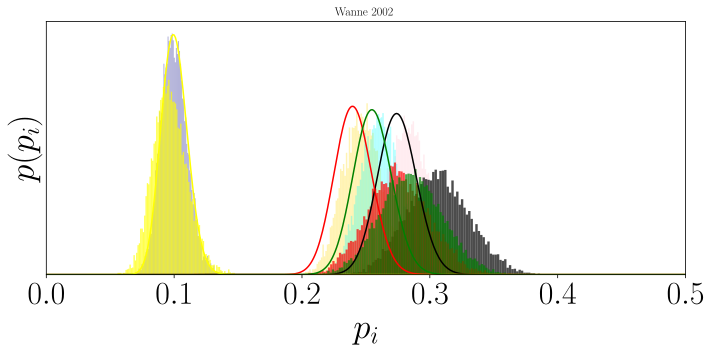

In [157]:
#unit test for 2002 Markt, i.e. the very first entry
ESS_pred_10k_Wanne_sm_Gaussian_2002 = ESS_pred_10k_Wanne_sm_Gaussian[:, 0, :]
LM_GP_pred_10k_Wanne_sm_2002 = LM_GP_pred_10k_Wanne_sm[:, 0, :]

mu_pred_Wanne_2002 = mu_pred_Wanne[0, :]
print(np.shape(mu_pred_Wanne_2002))

print(out["mpost"][n_parties:2*n_parties])
print(mu_pred_Wanne_2002)

Sigma_pred_Wanne_2002 = out["vpost"][n_parties:2*n_parties, n_parties:2*n_parties]
print(np.shape(Sigma_pred_Wanne_2002))

alphas_pred_2002 = Dirichlet_bridge_alpha(mu=mu_pred_Wanne_2002, Sigma=Sigma_pred_Wanne_2002)

print(alphas_pred_2002)

alpha_sum_2002 = alphas_pred_2002.sum()
alpha_0, beta_0 = alphas_pred_2002[0], alpha_sum_2002 - alphas_pred_2002[0]
alpha_1, beta_1 = alphas_pred_2002[1], alpha_sum_2002 - alphas_pred_2002[1]
alpha_2, beta_2 = alphas_pred_2002[2], alpha_sum_2002 - alphas_pred_2002[2]
alpha_3, beta_3 = alphas_pred_2002[3], alpha_sum_2002 - alphas_pred_2002[3]
alpha_4, beta_4 = alphas_pred_2002[4], alpha_sum_2002 - alphas_pred_2002[4]
alpha_5, beta_5 = alphas_pred_2002[5], alpha_sum_2002 - alphas_pred_2002[5]

x_beta = np.linspace(0, 1, 1000+1)
beta_func_0 = beta.pdf(x_beta, alpha_0, beta_0)
beta_func_1 = beta.pdf(x_beta, alpha_1, beta_1)
beta_func_2 = beta.pdf(x_beta, alpha_2, beta_2)
beta_func_3 = beta.pdf(x_beta, alpha_3, beta_3)
beta_func_4 = beta.pdf(x_beta, alpha_4, beta_4)
beta_func_5 = beta.pdf(x_beta, alpha_5, beta_5)


plt.figure(figsize=(10, 5))
plt.xlim(0, 0.5)
#plt.yticklabels([])
plt.yticks([])
plt.ylabel('$p(p_i)$')
plt.xlabel('$p_i$')

alpha0 = 0.7
alpha1 = 0.3

#LM_GP_colors = ['aqua', 'gold', 'royalblue', 'tomato', 'navy']
LM_GP_colors = ['pink', 'gold', 'navy', 'aqua', 'aqua']

plt.hist(LM_GP_pred_10k_Wanne_sm_2002[:,0], density=True, alpha=alpha1, bins=100, color=LM_GP_colors[0])
plt.hist(LM_GP_pred_10k_Wanne_sm_2002[:,1], density=True, alpha=alpha1, bins=100, color=LM_GP_colors[1])
plt.hist(LM_GP_pred_10k_Wanne_sm_2002[:,2], density=True, alpha=alpha1, bins=100, color=LM_GP_colors[2])
plt.hist(LM_GP_pred_10k_Wanne_sm_2002[:,3], density=True, alpha=alpha1, bins=100, color=LM_GP_colors[3])
#plt.hist(LM_GP_pred_10k_Wanne_sm_2002[:,4], density=True, alpha=alpha1, bins=100, color=LM_GP_colors[4])

plt.hist(ESS_pred_10k_Wanne_sm_Gaussian_2002[:,0], density=True, alpha=alpha0, bins=100, color=party_colors[parties[0]])
plt.hist(ESS_pred_10k_Wanne_sm_Gaussian_2002[:,1], density=True, alpha=alpha0, bins=100, color=party_colors[parties[1]])
plt.hist(ESS_pred_10k_Wanne_sm_Gaussian_2002[:,2], density=True, alpha=alpha0, bins=100, color=party_colors[parties[2]])
plt.hist(ESS_pred_10k_Wanne_sm_Gaussian_2002[:,3], density=True, alpha=alpha0, bins=100, color=party_colors[parties[3]])
#plt.hist(ESS_pred_10k_Wanne_sm_Gaussian_2002[:,4], density=True, alpha=alpha0, bins=100, color=party_colors[parties[4]])

plt.title("Wanne 2002")

plt.plot(x_beta, beta_func_0, color=party_colors[parties[0]])
plt.plot(x_beta, beta_func_1, color=party_colors[parties[1]])
plt.plot(x_beta, beta_func_2, color=party_colors[parties[2]])
plt.plot(x_beta, beta_func_3, color=party_colors[parties[3]])
#plt.plot(x_beta, beta_func_4, color=party_colors[parties[4]])

plt.tight_layout()
plt.savefig('Wanne_2002.pdf')

plt.show();

(9,)
[ 1.61903816  1.49822286  0.6200811   1.48549885 -0.56815921 -1.28019075
 -1.25940299 -1.32917486 -0.78591317]
[ 1.61903816  1.49822286  0.6200811   1.48549885 -0.56815921 -1.28019075
 -1.25940299 -1.32917486 -0.78591317]
(9, 9)
[252.21897318 226.9457004  106.02899956 225.81863173  38.36655732
  20.74232366  20.97005106  20.65229014  32.70188632]


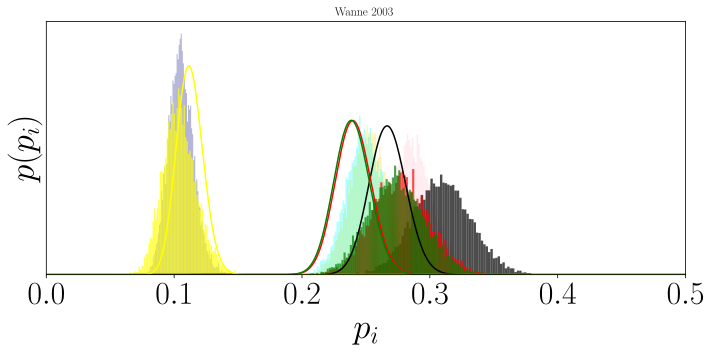

In [158]:
#unit test for 2002 Markt, i.e. the very first entry
ESS_pred_10k_Wanne_sm_Gaussian_2003 = ESS_pred_10k_Wanne_sm_Gaussian[:, 1, :]
LM_GP_pred_10k_Wanne_sm_2003 = LM_GP_pred_10k_Wanne_sm[:, 1, :]

mu_pred_Wanne_2003 = mu_pred_Wanne[1, :]
print(np.shape(mu_pred_Wanne_2003))

print(out["mpost"][(1*n_regions+1)*n_parties:(1*n_regions+2)*n_parties])
print(mu_pred_Wanne_2003)

Sigma_pred_Wanne_2003 = out["vpost"][(1*n_regions+1)*n_parties:(1*n_regions+2)*n_parties, (1*n_regions+1)*n_parties:(1*n_regions+2)*n_parties]
print(np.shape(Sigma_pred_Wanne_2003))

alphas_pred_2003 = Dirichlet_bridge_alpha(mu=mu_pred_Wanne_2003, Sigma=Sigma_pred_Wanne_2003)

print(alphas_pred_2003)

alpha_sum_2003 = alphas_pred_2003.sum()
alpha_0, beta_0 = alphas_pred_2003[0], alpha_sum_2003 - alphas_pred_2003[0]
alpha_1, beta_1 = alphas_pred_2003[1], alpha_sum_2003 - alphas_pred_2003[1]
alpha_2, beta_2 = alphas_pred_2003[2], alpha_sum_2003 - alphas_pred_2003[2]
alpha_3, beta_3 = alphas_pred_2003[3], alpha_sum_2003 - alphas_pred_2003[3]
alpha_4, beta_4 = alphas_pred_2003[4], alpha_sum_2003 - alphas_pred_2003[4]


from scipy.stats import beta

x_beta = np.linspace(0, 1, 1000+1)
beta_func_0 = beta.pdf(x_beta, alpha_0, beta_0)
beta_func_1 = beta.pdf(x_beta, alpha_1, beta_1)
beta_func_2 = beta.pdf(x_beta, alpha_2, beta_2)
beta_func_3 = beta.pdf(x_beta, alpha_3, beta_3)
beta_func_4 = beta.pdf(x_beta, alpha_4, beta_4)


plt.figure(figsize=(10, 5))
plt.xlim(0, 0.5)
#plt.yticklabels([])
plt.yticks([])
plt.ylabel('$p(p_i)$')
plt.xlabel('$p_i$')

alpha0 = 0.7
alpha1 = 0.3

#LM_GP_colors = ['aqua', 'gold', 'royalblue', 'tomato', 'navy']
LM_GP_colors = ['pink', 'gold', 'navy', 'aqua', 'aqua']

plt.hist(LM_GP_pred_10k_Wanne_sm_2003[:,0], density=True, alpha=alpha1, bins=100, color=LM_GP_colors[0])
plt.hist(LM_GP_pred_10k_Wanne_sm_2003[:,1], density=True, alpha=alpha1, bins=100, color=LM_GP_colors[1])
plt.hist(LM_GP_pred_10k_Wanne_sm_2003[:,2], density=True, alpha=alpha1, bins=100, color=LM_GP_colors[2])
plt.hist(LM_GP_pred_10k_Wanne_sm_2003[:,3], density=True, alpha=alpha1, bins=100, color=LM_GP_colors[3])
#plt.hist(LM_GP_pred_10k_Wanne_sm_2003[:,4], density=True, alpha=alpha1, bins=100, color=LM_GP_colors[4])

plt.hist(ESS_pred_10k_Wanne_sm_Gaussian_2003[:,0], density=True, alpha=alpha0, bins=100, color=party_colors[parties[0]])
plt.hist(ESS_pred_10k_Wanne_sm_Gaussian_2003[:,1], density=True, alpha=alpha0, bins=100, color=party_colors[parties[1]])
plt.hist(ESS_pred_10k_Wanne_sm_Gaussian_2003[:,2], density=True, alpha=alpha0, bins=100, color=party_colors[parties[2]])
plt.hist(ESS_pred_10k_Wanne_sm_Gaussian_2003[:,3], density=True, alpha=alpha0, bins=100, color=party_colors[parties[3]])
#plt.hist(ESS_pred_10k_Wanne_sm_Gaussian_2003[:,4], density=True, alpha=alpha0, bins=100, color=party_colors[parties[4]])

plt.title('Wanne 2003')

plt.plot(x_beta, beta_func_0, color=party_colors[parties[0]])
plt.plot(x_beta, beta_func_1, color=party_colors[parties[1]])
plt.plot(x_beta, beta_func_2, color=party_colors[parties[2]])
plt.plot(x_beta, beta_func_3, color=party_colors[parties[3]])
#plt.plot(x_beta, beta_func_4, color=party_colors[parties[4]])

plt.tight_layout()
plt.savefig('Wanne_2003.pdf')

plt.show();

(9,)
[ 1.60078643  1.50388701  0.68938377  1.42220868 -0.54336738 -1.29388605
 -1.22007879 -1.34411479 -0.81481887]
[ 1.60078643  1.50388701  0.68938377  1.42220868 -0.54336738 -1.29388605
 -1.22007879 -1.34411479 -0.81481887]
(9, 9)
[250.46976567 231.00204112 115.68314755 213.11945335  41.56325186
  22.50638073  23.24607041  22.40043775  33.61405018]


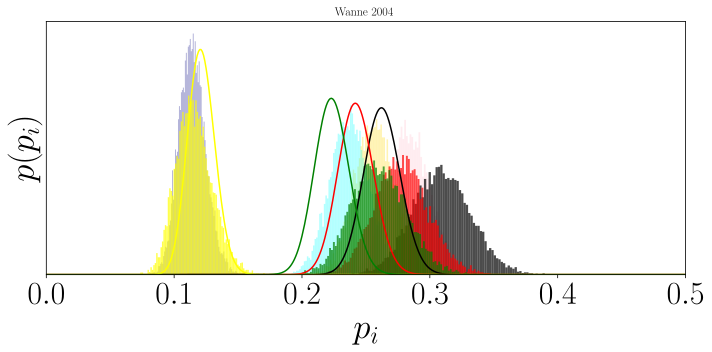

In [159]:
#unit test for 2002 Markt, i.e. the very first entry
ESS_pred_10k_Wanne_sm_Gaussian_2004 = ESS_pred_10k_Wanne_sm_Gaussian[:, 2, :]
LM_GP_pred_10k_Wanne_sm_2004 = LM_GP_pred_10k_Wanne_sm[:, 2, :]

mu_pred_Wanne_2004 = mu_pred_Wanne[2, :]
print(np.shape(mu_pred_Wanne_2004))

print(out["mpost"][(2*n_regions+1)*n_parties:(2*n_regions+2)*n_parties])
print(mu_pred_Wanne_2004)

Sigma_pred_Wanne_2004 = out["vpost"][(2*n_regions+1)*n_parties:(2*n_regions+2)*n_parties, (2*n_regions+1)*n_parties:(2*n_regions+2)*n_parties]
print(np.shape(Sigma_pred_Wanne_2004))

alphas_pred_2004 = Dirichlet_bridge_alpha(mu=mu_pred_Wanne_2004, Sigma=Sigma_pred_Wanne_2004)

print(alphas_pred_2004)

alpha_sum_2004 = alphas_pred_2004.sum()
alpha_0, beta_0 = alphas_pred_2004[0], alpha_sum_2004 - alphas_pred_2004[0]
alpha_1, beta_1 = alphas_pred_2004[1], alpha_sum_2004 - alphas_pred_2004[1]
alpha_2, beta_2 = alphas_pred_2004[2], alpha_sum_2004 - alphas_pred_2004[2]
alpha_3, beta_3 = alphas_pred_2004[3], alpha_sum_2004 - alphas_pred_2004[3]
alpha_4, beta_4 = alphas_pred_2004[4], alpha_sum_2004 - alphas_pred_2004[4]


from scipy.stats import beta

x_beta = np.linspace(0, 1, 1000+1)
beta_func_0 = beta.pdf(x_beta, alpha_0, beta_0)
beta_func_1 = beta.pdf(x_beta, alpha_1, beta_1)
beta_func_2 = beta.pdf(x_beta, alpha_2, beta_2)
beta_func_3 = beta.pdf(x_beta, alpha_3, beta_3)
beta_func_4 = beta.pdf(x_beta, alpha_4, beta_4)


plt.figure(figsize=(10, 5))
plt.xlim(0, 0.5)
#plt.yticklabels([])
plt.yticks([])
plt.ylabel('$p(p_i)$')
plt.xlabel('$p_i$')

alpha0 = 0.7
alpha1 = 0.3

#LM_GP_colors = ['aqua', 'gold', 'royalblue', 'tomato', 'navy']
LM_GP_colors = ['pink', 'gold', 'navy', 'aqua', 'aqua']

plt.hist(LM_GP_pred_10k_Wanne_sm_2004[:,0], density=True, alpha=alpha1, bins=100, color=LM_GP_colors[0])
plt.hist(LM_GP_pred_10k_Wanne_sm_2004[:,1], density=True, alpha=alpha1, bins=100, color=LM_GP_colors[1])
plt.hist(LM_GP_pred_10k_Wanne_sm_2004[:,2], density=True, alpha=alpha1, bins=100, color=LM_GP_colors[2])
plt.hist(LM_GP_pred_10k_Wanne_sm_2004[:,3], density=True, alpha=alpha1, bins=100, color=LM_GP_colors[3])
#plt.hist(LM_GP_pred_10k_Wanne_sm_2004[:,4], density=True, alpha=alpha1, bins=100, color=LM_GP_colors[4])

plt.hist(ESS_pred_10k_Wanne_sm_Gaussian_2004[:,0], density=True, alpha=alpha0, bins=100, color=party_colors[parties[0]])
plt.hist(ESS_pred_10k_Wanne_sm_Gaussian_2004[:,1], density=True, alpha=alpha0, bins=100, color=party_colors[parties[1]])
plt.hist(ESS_pred_10k_Wanne_sm_Gaussian_2004[:,2], density=True, alpha=alpha0, bins=100, color=party_colors[parties[2]])
plt.hist(ESS_pred_10k_Wanne_sm_Gaussian_2004[:,3], density=True, alpha=alpha0, bins=100, color=party_colors[parties[3]])
#plt.hist(ESS_pred_10k_Wanne_sm_Gaussian_2004[:,4], density=True, alpha=alpha0, bins=100, color=party_colors[parties[4]])

plt.title('Wanne 2004')

plt.plot(x_beta, beta_func_0, color=party_colors[parties[0]])
plt.plot(x_beta, beta_func_1, color=party_colors[parties[1]])
plt.plot(x_beta, beta_func_2, color=party_colors[parties[2]])
plt.plot(x_beta, beta_func_3, color=party_colors[parties[3]])
#plt.plot(x_beta, beta_func_4, color=party_colors[parties[4]])

plt.tight_layout()
plt.savefig('Wanne_2004.pdf')

plt.show();

(9,)
[ 1.60078643  1.50388701  0.68938377  1.42220868 -0.54336738 -1.29388605
 -1.22007879 -1.34411479 -0.81481887]
[ 1.60078643  1.50388701  0.68938377  1.42220868 -0.54336738 -1.29388605
 -1.22007879 -1.34411479 -0.81481887]
(9, 9)
[250.46976567 231.00204112 115.68314755 213.11945335  41.56325186
  22.50638073  23.24607041  22.40043775  33.61405018]


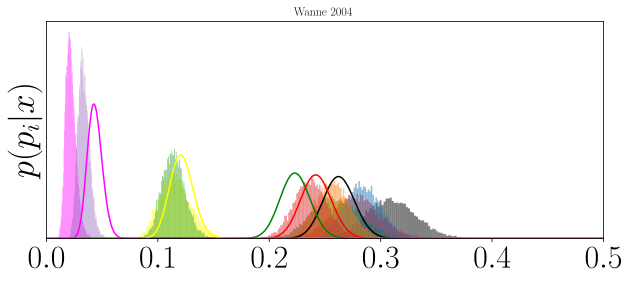

In [160]:
#unit test for 2002 Markt, i.e. the very first entry
ESS_pred_10k_Wanne_sm_Gaussian_2004 = ESS_pred_10k_Wanne_sm_Gaussian[:, 2, :]
LM_GP_pred_10k_Wanne_sm_2004 = LM_GP_pred_10k_Wanne_sm[:, 2, :]

mu_pred_Wanne_2004 = mu_pred_Wanne[2, :]
print(np.shape(mu_pred_Wanne_2004))

print(out["mpost"][(2*n_regions+1)*n_parties:(2*n_regions+2)*n_parties])
print(mu_pred_Wanne_2004)

Sigma_pred_Wanne_2004 = out["vpost"][(2*n_regions+1)*n_parties:(2*n_regions+2)*n_parties, (2*n_regions+1)*n_parties:(2*n_regions+2)*n_parties]
print(np.shape(Sigma_pred_Wanne_2004))

alphas_pred_2004 = Dirichlet_bridge_alpha(mu=mu_pred_Wanne_2004, Sigma=Sigma_pred_Wanne_2004)

print(alphas_pred_2004)

alpha_sum_2004 = alphas_pred_2004.sum()
alpha_0, beta_0 = alphas_pred_2004[0], alpha_sum_2004 - alphas_pred_2004[0]
alpha_1, beta_1 = alphas_pred_2004[1], alpha_sum_2004 - alphas_pred_2004[1]
alpha_2, beta_2 = alphas_pred_2004[2], alpha_sum_2004 - alphas_pred_2004[2]
alpha_3, beta_3 = alphas_pred_2004[3], alpha_sum_2004 - alphas_pred_2004[3]
alpha_4, beta_4 = alphas_pred_2004[4], alpha_sum_2004 - alphas_pred_2004[4]


from scipy.stats import beta

x_beta = np.linspace(0, 1, 1000+1)
beta_func_0 = beta.pdf(x_beta, alpha_0, beta_0)
beta_func_1 = beta.pdf(x_beta, alpha_1, beta_1)
beta_func_2 = beta.pdf(x_beta, alpha_2, beta_2)
beta_func_3 = beta.pdf(x_beta, alpha_3, beta_3)
beta_func_4 = beta.pdf(x_beta, alpha_4, beta_4)


plt.figure(figsize=(10, 4))
plt.xlim(0, 0.5)
#plt.yticklabels([])
plt.yticks([])
plt.ylabel('$p(p_i | x)$')


plt.hist(ESS_pred_10k_Wanne_sm_Gaussian_2004[:,0], density=True, alpha=0.5, bins=100, color=party_colors[parties[0]])
plt.hist(ESS_pred_10k_Wanne_sm_Gaussian_2004[:,1], density=True, alpha=0.5, bins=100, color=party_colors[parties[1]])
plt.hist(ESS_pred_10k_Wanne_sm_Gaussian_2004[:,2], density=True, alpha=0.5, bins=100, color=party_colors[parties[2]])
plt.hist(ESS_pred_10k_Wanne_sm_Gaussian_2004[:,3], density=True, alpha=0.5, bins=100, color=party_colors[parties[3]])
plt.hist(ESS_pred_10k_Wanne_sm_Gaussian_2004[:,4], density=True, alpha=0.5, bins=100, color=party_colors[parties[4]])

plt.hist(LM_GP_pred_10k_Wanne_sm_2004[:,0], density=True, alpha=0.5, bins=100)
plt.hist(LM_GP_pred_10k_Wanne_sm_2004[:,1], density=True, alpha=0.5, bins=100)
plt.hist(LM_GP_pred_10k_Wanne_sm_2004[:,2], density=True, alpha=0.5, bins=100)
plt.hist(LM_GP_pred_10k_Wanne_sm_2004[:,3], density=True, alpha=0.5, bins=100)
plt.hist(LM_GP_pred_10k_Wanne_sm_2004[:,4], density=True, alpha=0.5, bins=100)

plt.title('Wanne 2004')

plt.plot(x_beta, beta_func_0, color=party_colors[parties[0]])
plt.plot(x_beta, beta_func_1, color=party_colors[parties[1]])
plt.plot(x_beta, beta_func_2, color=party_colors[parties[2]])
plt.plot(x_beta, beta_func_3, color=party_colors[parties[3]])
plt.plot(x_beta, beta_func_4, color=party_colors[parties[4]])
plt.show();

(9,)
[ 0.67983762  1.36289262  0.07426335  2.05751657  0.53281119 -1.36206665
 -1.29036251 -1.39906348 -0.65582871]
[ 0.67983762  1.36289262  0.07426335  2.05751657  0.53281119 -1.36206665
 -1.29036251 -1.39906348 -0.65582871]
(9, 9)
[103.19427426 194.94736258  58.56724107 389.83431983  87.54703586
  17.37744535  17.54105026  17.32540837  31.75021124]


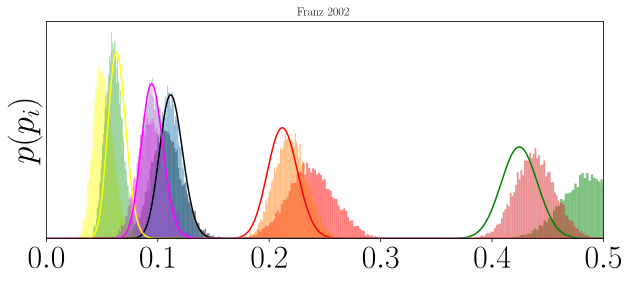

In [161]:
#unit test for 2002 Wanne, i.e. the very first entry
ESS_pred_10k_Franz_sm_Gaussian_2002 = ESS_pred_10k_Franz_sm_Gaussian[:, 0, :]
LM_GP_pred_10k_Franz_sm_2002 = LM_GP_pred_10k_Franz_sm[:, 0, :]

mu_pred_Franz_2002 = mu_pred_Franz[0, :]
print(np.shape(mu_pred_Franz_2002))

print(out["mpost"][(0*n_regions+2)*n_parties:(0*n_regions+3)*n_parties])
print(mu_pred_Franz_2002)

Sigma_pred_Franz_2002 = out["vpost"][(0*n_regions+2)*n_parties:(0*n_regions+3)*n_parties, (0*n_regions+2)*n_parties:(0*n_regions+3)*n_parties]
print(np.shape(Sigma_pred_Wanne_2002))

alphas_pred_2002 = Dirichlet_bridge_alpha(mu=mu_pred_Franz_2002, Sigma=Sigma_pred_Franz_2002)

print(alphas_pred_2002)

alpha_sum_2002 = alphas_pred_2002.sum()
alpha_0, beta_0 = alphas_pred_2002[0], alpha_sum_2002 - alphas_pred_2002[0]
alpha_1, beta_1 = alphas_pred_2002[1], alpha_sum_2002 - alphas_pred_2002[1]
alpha_2, beta_2 = alphas_pred_2002[2], alpha_sum_2002 - alphas_pred_2002[2]
alpha_3, beta_3 = alphas_pred_2002[3], alpha_sum_2002 - alphas_pred_2002[3]
alpha_4, beta_4 = alphas_pred_2002[4], alpha_sum_2002 - alphas_pred_2002[4]


from scipy.stats import beta

x_beta = np.linspace(0, 1, 1000+1)
beta_func_0 = beta.pdf(x_beta, alpha_0, beta_0)
beta_func_1 = beta.pdf(x_beta, alpha_1, beta_1)
beta_func_2 = beta.pdf(x_beta, alpha_2, beta_2)
beta_func_3 = beta.pdf(x_beta, alpha_3, beta_3)
beta_func_4 = beta.pdf(x_beta, alpha_4, beta_4)


plt.figure(figsize=(10, 4))
plt.xlim(0, 0.5)
#plt.yticklabels([])
plt.yticks([])
plt.ylabel('$p(p_i)$')


plt.hist(ESS_pred_10k_Franz_sm_Gaussian_2002[:,0], density=True, alpha=0.5, bins=100, color=party_colors[parties[0]])
plt.hist(ESS_pred_10k_Franz_sm_Gaussian_2002[:,1], density=True, alpha=0.5, bins=100, color=party_colors[parties[1]])
plt.hist(ESS_pred_10k_Franz_sm_Gaussian_2002[:,2], density=True, alpha=0.5, bins=100, color=party_colors[parties[2]])
plt.hist(ESS_pred_10k_Franz_sm_Gaussian_2002[:,3], density=True, alpha=0.5, bins=100, color=party_colors[parties[3]])
plt.hist(ESS_pred_10k_Franz_sm_Gaussian_2002[:,4], density=True, alpha=0.5, bins=100, color=party_colors[parties[4]])

plt.hist(LM_GP_pred_10k_Franz_sm_2002[:,0], density=True, alpha=0.5, bins=100)
plt.hist(LM_GP_pred_10k_Franz_sm_2002[:,1], density=True, alpha=0.5, bins=100)
plt.hist(LM_GP_pred_10k_Franz_sm_2002[:,2], density=True, alpha=0.5, bins=100)
plt.hist(LM_GP_pred_10k_Franz_sm_2002[:,3], density=True, alpha=0.5, bins=100)
plt.hist(LM_GP_pred_10k_Franz_sm_2002[:,4], density=True, alpha=0.5, bins=100)

plt.title('Franz 2002')

plt.plot(x_beta, beta_func_0, color=party_colors[parties[0]])
plt.plot(x_beta, beta_func_1, color=party_colors[parties[1]])
plt.plot(x_beta, beta_func_2, color=party_colors[parties[2]])
plt.plot(x_beta, beta_func_3, color=party_colors[parties[3]])
plt.plot(x_beta, beta_func_4, color=party_colors[parties[4]])
plt.show();

(9,)
[ 0.61754728  1.40742319  0.10247261  2.05144147  0.58814749 -1.3933461
 -1.25856251 -1.42719714 -0.6879263 ]
[ 0.61754728  1.40742319  0.10247261  2.05144147  0.58814749 -1.3933461
 -1.25856251 -1.42719714 -0.6879263 ]
(9, 9)
[114.39913034 221.69211815  73.18739948 394.65648419 109.70727075
  20.67397423  21.19281143  20.61599145  38.15958714]


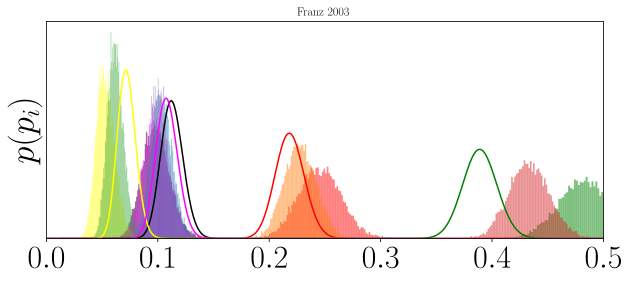

In [162]:
#unit test for 2002 Wanne, i.e. the very first entry
ESS_pred_10k_Franz_sm_Gaussian_2003 = ESS_pred_10k_Franz_sm_Gaussian[:, 1, :]
LM_GP_pred_10k_Franz_sm_2003 = LM_GP_pred_10k_Franz_sm[:, 1, :]

mu_pred_Franz_2003 = mu_pred_Franz[1, :]
print(np.shape(mu_pred_Franz_2003))

print(out["mpost"][(1*n_regions+2)*n_parties:(1*n_regions+3)*n_parties])
print(mu_pred_Franz_2003)

Sigma_pred_Franz_2003 = out["vpost"][(1*n_regions+2)*n_parties:(1*n_regions+3)*n_parties, (1*n_regions+2)*n_parties:(1*n_regions+3)*n_parties]
print(np.shape(Sigma_pred_Wanne_2003))

alphas_pred_2003 = Dirichlet_bridge_alpha(mu=mu_pred_Franz_2003, Sigma=Sigma_pred_Franz_2003)

print(alphas_pred_2003)

alpha_sum_2003 = alphas_pred_2003.sum()
alpha_0, beta_0 = alphas_pred_2003[0], alpha_sum_2003 - alphas_pred_2003[0]
alpha_1, beta_1 = alphas_pred_2003[1], alpha_sum_2003 - alphas_pred_2003[1]
alpha_2, beta_2 = alphas_pred_2003[2], alpha_sum_2003 - alphas_pred_2003[2]
alpha_3, beta_3 = alphas_pred_2003[3], alpha_sum_2003 - alphas_pred_2003[3]
alpha_4, beta_4 = alphas_pred_2003[4], alpha_sum_2003 - alphas_pred_2003[4]


from scipy.stats import beta

x_beta = np.linspace(0, 1, 1000+1)
beta_func_0 = beta.pdf(x_beta, alpha_0, beta_0)
beta_func_1 = beta.pdf(x_beta, alpha_1, beta_1)
beta_func_2 = beta.pdf(x_beta, alpha_2, beta_2)
beta_func_3 = beta.pdf(x_beta, alpha_3, beta_3)
beta_func_4 = beta.pdf(x_beta, alpha_4, beta_4)


plt.figure(figsize=(10, 4))
plt.xlim(0, 0.5)
#plt.yticklabels([])
plt.yticks([])
plt.ylabel('$p(p_i)$')


plt.hist(ESS_pred_10k_Franz_sm_Gaussian_2003[:,0], density=True, alpha=0.5, bins=100, color=party_colors[parties[0]])
plt.hist(ESS_pred_10k_Franz_sm_Gaussian_2003[:,1], density=True, alpha=0.5, bins=100, color=party_colors[parties[1]])
plt.hist(ESS_pred_10k_Franz_sm_Gaussian_2003[:,2], density=True, alpha=0.5, bins=100, color=party_colors[parties[2]])
plt.hist(ESS_pred_10k_Franz_sm_Gaussian_2003[:,3], density=True, alpha=0.5, bins=100, color=party_colors[parties[3]])
plt.hist(ESS_pred_10k_Franz_sm_Gaussian_2003[:,4], density=True, alpha=0.5, bins=100, color=party_colors[parties[4]])

plt.hist(LM_GP_pred_10k_Franz_sm_2003[:,0], density=True, alpha=0.5, bins=100)
plt.hist(LM_GP_pred_10k_Franz_sm_2003[:,1], density=True, alpha=0.5, bins=100)
plt.hist(LM_GP_pred_10k_Franz_sm_2003[:,2], density=True, alpha=0.5, bins=100)
plt.hist(LM_GP_pred_10k_Franz_sm_2003[:,3], density=True, alpha=0.5, bins=100)
plt.hist(LM_GP_pred_10k_Franz_sm_2003[:,4], density=True, alpha=0.5, bins=100)

plt.title('Franz 2003')

plt.plot(x_beta, beta_func_0, color=party_colors[parties[0]])
plt.plot(x_beta, beta_func_1, color=party_colors[parties[1]])
plt.plot(x_beta, beta_func_2, color=party_colors[parties[2]])
plt.plot(x_beta, beta_func_3, color=party_colors[parties[3]])
plt.plot(x_beta, beta_func_4, color=party_colors[parties[4]])
plt.show();

# Another playground
this time only for ground truth data and no predictions

In [1]:
def training_samples_sm_cum(samples, all=False):
    
    training_samples_Markt_sm_cum = []
    training_samples_Wanne_sm_cum = []
    training_samples_Franz_sm_cum = []

    if all: 
        training_samples_sm_cum_all = []
        
        for s in samples:
            
            s = s.reshape((-1, n_parties))
            sm_s = softmax_batch(s)
            sm_s_cum = np.cumsum(sm_s, 1)
        
            training_samples_sm_cum_all.append(sm_s_cum)
        
        return(np.array(training_samples_sm_cum_all))
    
    else: 
        for s in samples:

            s = s.reshape((-1, n_regions*n_parties))

            sample_pred_Markt = s[:, :n_parties]
            sample_pred_Wanne = s[:, n_parties:2*n_parties]
            sample_pred_Franz = s[:, 2*n_parties:3*n_parties]

            sm_s_results_Markt = softmax_batch(sample_pred_Markt)
            sm_s_cumulative_Markt = np.cumsum(sm_s_results_Markt, 1)

            sm_s_results_Wanne = softmax_batch(sample_pred_Wanne)
            sm_s_cumulative_Wanne = np.cumsum(sm_s_results_Wanne, 1)

            sm_s_results_Franz = softmax_batch(sample_pred_Franz)
            sm_s_cumulative_Franz = np.cumsum(sm_s_results_Franz, 1)

            training_samples_Markt_sm_cum.append(sm_s_cumulative_Markt)
            training_samples_Wanne_sm_cum.append(sm_s_cumulative_Wanne)
            training_samples_Franz_sm_cum.append(sm_s_cumulative_Franz)

        training_samples_Markt_sm_cum = np.array(training_samples_Markt_sm_cum)
        training_samples_Wanne_sm_cum = np.array(training_samples_Wanne_sm_cum)
        training_samples_Franz_sm_cum = np.array(training_samples_Franz_sm_cum)

        return(training_samples_Markt_sm_cum,
               training_samples_Wanne_sm_cum,
               training_samples_Franz_sm_cum)

In [2]:
training_samples_Markt_sm_cum_10k, training_samples_Wanne_sm_cum_10k, training_samples_Franz_sm_cum_10k = training_samples_sm_cum(post_samples_10k)
training_samples_All_sm_cum_10k = training_samples_sm_cum(post_samples_10k, all=True)

NameError: name 'post_samples_10k' is not defined

In [ ]:
print(np.shape(training_samples_Markt_sm_cum_10k))

training_samples_Markt_sm_cum_mean_10k = np.mean(training_samples_Markt_sm_cum_10k, 0)
training_samples_Markt_sm_cum_std_10k = np.std(training_samples_Markt_sm_cum_10k, 0)

training_samples_Wanne_sm_cum_mean_10k = np.mean(training_samples_Wanne_sm_cum_10k, 0)
training_samples_Wanne_sm_cum_std_10k = np.std(training_samples_Wanne_sm_cum_10k, 0)

training_samples_Franz_sm_cum_mean_10k = np.mean(training_samples_Franz_sm_cum_10k, 0)
training_samples_Franz_sm_cum_std_10k = np.std(training_samples_Franz_sm_cum_10k, 0)

training_samples_All_sm_cum_mean_10k = np.mean(training_samples_All_sm_cum_10k, 0)
training_samples_All_sm_cum_std_10k = np.std(training_samples_All_sm_cum_10k, 0)

print(np.shape(training_samples_All_sm_cum_mean_10k))

In [ ]:
fig, ax = plt.subplots(2, 3, figsize=(16, 8))

ax[0][0].plot(training_samples_Markt_sm_cum_mean_10k)
ax[0][1].plot(training_samples_Wanne_sm_cum_mean_10k)
ax[0][2].plot(training_samples_Franz_sm_cum_mean_10k)

ax[1][0].plot(training_samples_Markt_sm_cum_std_10k)
ax[1][1].plot(training_samples_Wanne_sm_cum_std_10k)
ax[1][2].plot(training_samples_Franz_sm_cum_std_10k)

plt.show();

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(16, 8))

ax[0].plot(training_samples_All_sm_cum_mean_10k)

ax[1].plot(training_samples_All_sm_cum_std_10k)

plt.show();

In [ ]:
# repeat for 5 samples

training_samples_Markt_sm_cum_5, training_samples_Wanne_sm_cum_5, training_samples_Franz_sm_cum_5 = training_samples_sm_cum(post_samples_5)


training_samples_Markt_sm_cum_mean_5 = np.mean(training_samples_Markt_sm_cum_5, 0)
training_samples_Markt_sm_cum_std_5 = np.std(training_samples_Markt_sm_cum_5, 0)

training_samples_Wanne_sm_cum_mean_5 = np.mean(training_samples_Wanne_sm_cum_5, 0)
training_samples_Wanne_sm_cum_std_5 = np.std(training_samples_Wanne_sm_cum_5, 0)

training_samples_Franz_sm_cum_mean_5 = np.mean(training_samples_Franz_sm_cum_5, 0)
training_samples_Franz_sm_cum_std_5 = np.std(training_samples_Franz_sm_cum_5, 0)

fig, ax = plt.subplots(2, 3, figsize=(16, 8))

ax[0][0].plot(training_samples_Markt_sm_cum_mean_5)
ax[0][1].plot(training_samples_Wanne_sm_cum_mean_5)
ax[0][2].plot(training_samples_Franz_sm_cum_mean_5)

ax[1][0].plot(training_samples_Markt_sm_cum_std_5)
ax[1][1].plot(training_samples_Wanne_sm_cum_std_5)
ax[1][2].plot(training_samples_Franz_sm_cum_std_5)

plt.show();

## compare to Laplace Matching

In [ ]:
n_GP_train_samples = 10000
train_GP_samples = multivariate_normal(
    Y_mu.flatten(), Y_Sigma_block, size=n_GP_train_samples
)

In [ ]:
Y_mu_ = Y_mu.reshape((-1, n_regions*n_parties))
    
GP_mean_train_Markt = Y_mu_[:, :n_parties]
GP_mean_train_Wanne = Y_mu_[:, n_parties:2*n_parties]
GP_mean_train_Franz = Y_mu_[:, 2*n_parties:3*n_parties]

sm_GP_train_results_Markt = softmax_batch(GP_mean_train_Markt)
sm_GP_train_cumulative_Markt = np.cumsum(sm_GP_train_results_Markt, 1)

sm_GP_train_results_Wanne = softmax_batch(GP_mean_train_Wanne)
sm_GP_train_cumulative_Wanne = np.cumsum(sm_GP_train_results_Wanne, 1)

sm_GP_train_results_Franz = softmax_batch(GP_mean_train_Franz)
sm_GP_train_cumulative_Franz = np.cumsum(sm_GP_train_results_Franz, 1)

sm_GP_train_results_all = softmax_batch(Y_mu_.reshape(-1, n_parties))
sm_GP_train_cumulative_all = np.cumsum(sm_GP_train_results_all, 1)

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(16, 4))

ax[0].plot(sm_GP_train_cumulative_Markt)
ax[1].plot(sm_GP_train_cumulative_Wanne)
ax[2].plot(sm_GP_train_cumulative_Franz)

plt.show();

In [ ]:
plt.figure(figsize=(16, 4))

plt.plot(sm_GP_train_cumulative_all)
plt.show();

In [ ]:
training_GP_samples_Markt_sm_cum_10k, training_GP_samples_Wanne_sm_cum_10k, training_GP_samples_Franz_sm_cum_10k = training_samples_sm_cum(train_GP_samples)
training_GP_samples_All_sm_cum_10k = training_samples_sm_cum(train_GP_samples, all=True)

In [ ]:
print(np.shape(training_GP_samples_Markt_sm_cum_10k))

training_GP_samples_Markt_sm_cum_mean_10k = np.mean(training_GP_samples_Markt_sm_cum_10k, 0)
training_GP_samples_Markt_sm_cum_std_10k = np.std(training_GP_samples_Markt_sm_cum_10k, 0)

training_GP_samples_Wanne_sm_cum_mean_10k = np.mean(training_GP_samples_Wanne_sm_cum_10k, 0)
training_GP_samples_Wanne_sm_cum_std_10k = np.std(training_GP_samples_Wanne_sm_cum_10k, 0)

training_GP_samples_Franz_sm_cum_mean_10k = np.mean(training_GP_samples_Franz_sm_cum_10k, 0)
training_GP_samples_Franz_sm_cum_std_10k = np.std(training_GP_samples_Franz_sm_cum_10k, 0)

training_GP_samples_All_sm_cum_mean_10k = np.mean(training_GP_samples_All_sm_cum_10k, 0)
training_GP_samples_All_sm_cum_std_10k = np.std(training_GP_samples_All_sm_cum_10k, 0)

In [ ]:
fig, ax = plt.subplots(2, 3, figsize=(10, 5))

ax[0][0].plot(training_GP_samples_Markt_sm_cum_mean_10k)
ax[0][1].plot(training_GP_samples_Wanne_sm_cum_mean_10k)
ax[0][2].plot(training_GP_samples_Franz_sm_cum_mean_10k)

ax[1][0].plot(training_GP_samples_Markt_sm_cum_std_10k)
ax[1][1].plot(training_GP_samples_Wanne_sm_cum_std_10k)
ax[1][2].plot(training_GP_samples_Franz_sm_cum_std_10k)

plt.show();

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(10, 5))

ax[0].plot(training_GP_samples_All_sm_cum_mean_10k)

ax[1].plot(training_GP_samples_All_sm_cum_std_10k)

plt.show();

In [ ]:
# compare to ESS samples

fig, ax = plt.subplots(2, 1, figsize=(16, 8))

ax[0].plot(training_samples_All_sm_cum_mean_10k)

ax[1].plot(training_samples_All_sm_cum_std_10k)

plt.show();

# Compute the distances

In [ ]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

def mean_abs_diff(pred, targets):
    return(np.mean(np.abs(pred - targets)))

In [ ]:
# apply the computations to all samples

training_samples_All_sm_cum_1 = training_samples_sm_cum(post_samples_1, all=True)
training_samples_All_sm_cum_2 = training_samples_sm_cum(post_samples_2, all=True)
training_samples_All_sm_cum_3 = training_samples_sm_cum(post_samples_3, all=True)
training_samples_All_sm_cum_4 = training_samples_sm_cum(post_samples_4, all=True)
training_samples_All_sm_cum_5 = training_samples_sm_cum(post_samples_5, all=True)
training_samples_All_sm_cum_10 = training_samples_sm_cum(post_samples_10, all=True)
training_samples_All_sm_cum_50 = training_samples_sm_cum(post_samples_50, all=True)
training_samples_All_sm_cum_100 = training_samples_sm_cum(post_samples_100, all=True)
training_samples_All_sm_cum_500 = training_samples_sm_cum(post_samples_500, all=True)
training_samples_All_sm_cum_1k = training_samples_sm_cum(post_samples_1k, all=True)
training_samples_All_sm_cum_2k = training_samples_sm_cum(post_samples_2k, all=True)
training_samples_All_sm_cum_3k = training_samples_sm_cum(post_samples_3k, all=True)
training_samples_All_sm_cum_4k = training_samples_sm_cum(post_samples_4k, all=True)
training_samples_All_sm_cum_5k = training_samples_sm_cum(post_samples_5k, all=True)
training_samples_All_sm_cum_6k = training_samples_sm_cum(post_samples_6k, all=True)
training_samples_All_sm_cum_7k = training_samples_sm_cum(post_samples_7k, all=True)
training_samples_All_sm_cum_8k = training_samples_sm_cum(post_samples_8k, all=True)
training_samples_All_sm_cum_9k = training_samples_sm_cum(post_samples_9k, all=True)
training_samples_All_sm_cum_10k = training_samples_sm_cum(post_samples_10k, all=True)

In [3]:
# compute mean and std for all samples

training_samples_All_sm_cum_mean_1 = np.mean(training_samples_All_sm_cum_1, 0)

training_samples_All_sm_cum_mean_2 = np.mean(training_samples_All_sm_cum_2, 0)
training_samples_All_sm_cum_std_2 = np.std(training_samples_All_sm_cum_2, 0)

training_samples_All_sm_cum_mean_3 = np.mean(training_samples_All_sm_cum_3, 0)
training_samples_All_sm_cum_std_3 = np.std(training_samples_All_sm_cum_3, 0)

training_samples_All_sm_cum_mean_4 = np.mean(training_samples_All_sm_cum_4, 0)
training_samples_All_sm_cum_std_4 = np.std(training_samples_All_sm_cum_4, 0)

training_samples_All_sm_cum_mean_5 = np.mean(training_samples_All_sm_cum_5, 0)
training_samples_All_sm_cum_std_5 = np.std(training_samples_All_sm_cum_5, 0)

training_samples_All_sm_cum_mean_10 = np.mean(training_samples_All_sm_cum_10, 0)
training_samples_All_sm_cum_std_10 = np.std(training_samples_All_sm_cum_10, 0)

training_samples_All_sm_cum_mean_50 = np.mean(training_samples_All_sm_cum_50, 0)
training_samples_All_sm_cum_std_50 = np.std(training_samples_All_sm_cum_50, 0)

training_samples_All_sm_cum_mean_100 = np.mean(training_samples_All_sm_cum_100, 0)
training_samples_All_sm_cum_std_100 = np.std(training_samples_All_sm_cum_100, 0)

training_samples_All_sm_cum_mean_500 = np.mean(training_samples_All_sm_cum_500, 0)
training_samples_All_sm_cum_std_500 = np.std(training_samples_All_sm_cum_500, 0)

training_samples_All_sm_cum_mean_1k = np.mean(training_samples_All_sm_cum_1k, 0)
training_samples_All_sm_cum_std_1k = np.std(training_samples_All_sm_cum_1k, 0)

training_samples_All_sm_cum_mean_2k = np.mean(training_samples_All_sm_cum_2k, 0)
training_samples_All_sm_cum_std_2k = np.std(training_samples_All_sm_cum_2k, 0)

training_samples_All_sm_cum_mean_3k = np.mean(training_samples_All_sm_cum_3k, 0)
training_samples_All_sm_cum_std_3k = np.std(training_samples_All_sm_cum_3k, 0)

training_samples_All_sm_cum_mean_4k = np.mean(training_samples_All_sm_cum_4k, 0)
training_samples_All_sm_cum_std_4k = np.std(training_samples_All_sm_cum_4k, 0)

training_samples_All_sm_cum_mean_5k = np.mean(training_samples_All_sm_cum_5k, 0)
training_samples_All_sm_cum_std_5k = np.std(training_samples_All_sm_cum_5k, 0)

training_samples_All_sm_cum_mean_6k = np.mean(training_samples_All_sm_cum_6k, 0)
training_samples_All_sm_cum_std_6k = np.std(training_samples_All_sm_cum_6k, 0)

training_samples_All_sm_cum_mean_7k = np.mean(training_samples_All_sm_cum_7k, 0)
training_samples_All_sm_cum_std_7k = np.std(training_samples_All_sm_cum_7k, 0)

training_samples_All_sm_cum_mean_8k = np.mean(training_samples_All_sm_cum_8k, 0)
training_samples_All_sm_cum_std_8k = np.std(training_samples_All_sm_cum_8k, 0)

training_samples_All_sm_cum_mean_9k = np.mean(training_samples_All_sm_cum_9k, 0)
training_samples_All_sm_cum_std_9k = np.std(training_samples_All_sm_cum_9k, 0)

training_samples_All_sm_cum_mean_10k = np.mean(training_samples_All_sm_cum_10k, 0)
training_samples_All_sm_cum_std_10k = np.std(training_samples_All_sm_cum_10k, 0)

NameError: name 'np' is not defined

In [ ]:
# compute the resulting differences for the mean with rmse

rmse_LM_GP_mean = rmse(sm_GP_train_cumulative_all, training_samples_All_sm_cum_mean_10k)
rmse_LM_GP_s_mean = rmse(training_GP_samples_All_sm_cum_mean_10k, training_samples_All_sm_cum_mean_10k)
rmse_s_mean_1 = rmse(training_samples_All_sm_cum_mean_1, training_samples_All_sm_cum_mean_10k)
rmse_s_mean_2 = rmse(training_samples_All_sm_cum_mean_2, training_samples_All_sm_cum_mean_10k)
rmse_s_mean_3 = rmse(training_samples_All_sm_cum_mean_3, training_samples_All_sm_cum_mean_10k)
rmse_s_mean_4 = rmse(training_samples_All_sm_cum_mean_4, training_samples_All_sm_cum_mean_10k)
rmse_s_mean_5 = rmse(training_samples_All_sm_cum_mean_5, training_samples_All_sm_cum_mean_10k)
rmse_s_mean_10 = rmse(training_samples_All_sm_cum_mean_10, training_samples_All_sm_cum_mean_10k)
rmse_s_mean_50 = rmse(training_samples_All_sm_cum_mean_50, training_samples_All_sm_cum_mean_10k)
rmse_s_mean_100 = rmse(training_samples_All_sm_cum_mean_100, training_samples_All_sm_cum_mean_10k)
rmse_s_mean_500 = rmse(training_samples_All_sm_cum_mean_500, training_samples_All_sm_cum_mean_10k)
rmse_s_mean_1k = rmse(training_samples_All_sm_cum_mean_1k, training_samples_All_sm_cum_mean_10k)
rmse_s_mean_2k = rmse(training_samples_All_sm_cum_mean_2k, training_samples_All_sm_cum_mean_10k)
rmse_s_mean_3k = rmse(training_samples_All_sm_cum_mean_3k, training_samples_All_sm_cum_mean_10k)
rmse_s_mean_4k = rmse(training_samples_All_sm_cum_mean_4k, training_samples_All_sm_cum_mean_10k)
rmse_s_mean_5k = rmse(training_samples_All_sm_cum_mean_5k, training_samples_All_sm_cum_mean_10k)
rmse_s_mean_6k = rmse(training_samples_All_sm_cum_mean_6k, training_samples_All_sm_cum_mean_10k)
rmse_s_mean_7k = rmse(training_samples_All_sm_cum_mean_7k, training_samples_All_sm_cum_mean_10k)
rmse_s_mean_8k = rmse(training_samples_All_sm_cum_mean_8k, training_samples_All_sm_cum_mean_10k)
rmse_s_mean_9k = rmse(training_samples_All_sm_cum_mean_9k, training_samples_All_sm_cum_mean_10k)
rmse_s_mean_10k = rmse(training_samples_All_sm_cum_mean_10k, training_samples_All_sm_cum_mean_10k)

print(rmse_LM_GP_mean)
print(rmse_LM_GP_s_mean)
print(rmse_s_mean_1)
print(rmse_s_mean_2)
print(rmse_s_mean_3)
print(rmse_s_mean_4)
print(rmse_s_mean_5)
print(rmse_s_mean_10)
print(rmse_s_mean_50)
print(rmse_s_mean_100)
print(rmse_s_mean_500)
print(rmse_s_mean_1k)
print(rmse_s_mean_2k)
print(rmse_s_mean_3k)
print(rmse_s_mean_4k)
print(rmse_s_mean_5k)
print(rmse_s_mean_6k)
print(rmse_s_mean_7k)
print(rmse_s_mean_8k)
print(rmse_s_mean_9k)
print(rmse_s_mean_10k)

In [ ]:
# compute the resulting differences for the mean and mean absolute difference

mad_LM_GP_mean = mean_abs_diff(sm_GP_train_cumulative_all, training_samples_All_sm_cum_mean_10k)
mad_LM_GP_s_mean = mean_abs_diff(training_GP_samples_All_sm_cum_mean_10k, training_samples_All_sm_cum_mean_10k)
mad_s_mean_1 = mean_abs_diff(training_samples_All_sm_cum_mean_1, training_samples_All_sm_cum_mean_10k)
mad_s_mean_2 = mean_abs_diff(training_samples_All_sm_cum_mean_2, training_samples_All_sm_cum_mean_10k)
mad_s_mean_3 = mean_abs_diff(training_samples_All_sm_cum_mean_3, training_samples_All_sm_cum_mean_10k)
mad_s_mean_4 = mean_abs_diff(training_samples_All_sm_cum_mean_4, training_samples_All_sm_cum_mean_10k)
mad_s_mean_5 = mean_abs_diff(training_samples_All_sm_cum_mean_5, training_samples_All_sm_cum_mean_10k)
mad_s_mean_10 = mean_abs_diff(training_samples_All_sm_cum_mean_10, training_samples_All_sm_cum_mean_10k)
mad_s_mean_50 = mean_abs_diff(training_samples_All_sm_cum_mean_50, training_samples_All_sm_cum_mean_10k)
mad_s_mean_100 = mean_abs_diff(training_samples_All_sm_cum_mean_100, training_samples_All_sm_cum_mean_10k)
mad_s_mean_500 = mean_abs_diff(training_samples_All_sm_cum_mean_500, training_samples_All_sm_cum_mean_10k)
mad_s_mean_1k = mean_abs_diff(training_samples_All_sm_cum_mean_1k, training_samples_All_sm_cum_mean_10k)
mad_s_mean_2k = mean_abs_diff(training_samples_All_sm_cum_mean_2k, training_samples_All_sm_cum_mean_10k)
mad_s_mean_3k = mean_abs_diff(training_samples_All_sm_cum_mean_3k, training_samples_All_sm_cum_mean_10k)
mad_s_mean_4k = mean_abs_diff(training_samples_All_sm_cum_mean_4k, training_samples_All_sm_cum_mean_10k)
mad_s_mean_5k = mean_abs_diff(training_samples_All_sm_cum_mean_5k, training_samples_All_sm_cum_mean_10k)
mad_s_mean_6k = mean_abs_diff(training_samples_All_sm_cum_mean_6k, training_samples_All_sm_cum_mean_10k)
mad_s_mean_7k = mean_abs_diff(training_samples_All_sm_cum_mean_7k, training_samples_All_sm_cum_mean_10k)
mad_s_mean_8k = mean_abs_diff(training_samples_All_sm_cum_mean_8k, training_samples_All_sm_cum_mean_10k)
mad_s_mean_9k = mean_abs_diff(training_samples_All_sm_cum_mean_9k, training_samples_All_sm_cum_mean_10k)
mad_s_mean_10k = mean_abs_diff(training_samples_All_sm_cum_mean_10k, training_samples_All_sm_cum_mean_10k)

print(mad_LM_GP_mean)
print(mad_LM_GP_s_mean)
print(mad_s_mean_1)
print(mad_s_mean_2)
print(mad_s_mean_3)
print(mad_s_mean_4)
print(mad_s_mean_5)
print(mad_s_mean_10)
print(mad_s_mean_50)
print(mad_s_mean_100)
print(mad_s_mean_500)
print(mad_s_mean_1k)
print(mad_s_mean_2k)
print(mad_s_mean_3k)
print(mad_s_mean_4k)
print(mad_s_mean_5k)
print(mad_s_mean_6k)
print(mad_s_mean_7k)
print(mad_s_mean_8k)
print(mad_s_mean_9k)
print(mad_s_mean_10k)

In [ ]:
# compute the resulting differences for the std with rmse

rmse_LM_GP_s_std = rmse(training_GP_samples_All_sm_cum_std_10k, training_samples_All_sm_cum_std_10k)
rmse_s_std_2 = rmse(training_samples_All_sm_cum_std_2, training_samples_All_sm_cum_std_10k)
rmse_s_std_3 = rmse(training_samples_All_sm_cum_std_3, training_samples_All_sm_cum_std_10k)
rmse_s_std_4 = rmse(training_samples_All_sm_cum_std_4, training_samples_All_sm_cum_std_10k)
rmse_s_std_5 = rmse(training_samples_All_sm_cum_std_5, training_samples_All_sm_cum_std_10k)
rmse_s_std_10 = rmse(training_samples_All_sm_cum_std_10, training_samples_All_sm_cum_std_10k)
rmse_s_std_50 = rmse(training_samples_All_sm_cum_std_50, training_samples_All_sm_cum_std_10k)
rmse_s_std_100 = rmse(training_samples_All_sm_cum_std_100, training_samples_All_sm_cum_std_10k)
rmse_s_std_500 = rmse(training_samples_All_sm_cum_std_500, training_samples_All_sm_cum_std_10k)
rmse_s_std_1k = rmse(training_samples_All_sm_cum_std_1k, training_samples_All_sm_cum_std_10k)
rmse_s_std_2k = rmse(training_samples_All_sm_cum_std_2k, training_samples_All_sm_cum_std_10k)
rmse_s_std_3k = rmse(training_samples_All_sm_cum_std_3k, training_samples_All_sm_cum_std_10k)
rmse_s_std_4k = rmse(training_samples_All_sm_cum_std_4k, training_samples_All_sm_cum_std_10k)
rmse_s_std_5k = rmse(training_samples_All_sm_cum_std_5k, training_samples_All_sm_cum_std_10k)
rmse_s_std_6k = rmse(training_samples_All_sm_cum_std_6k, training_samples_All_sm_cum_std_10k)
rmse_s_std_7k = rmse(training_samples_All_sm_cum_std_7k, training_samples_All_sm_cum_std_10k)
rmse_s_std_8k = rmse(training_samples_All_sm_cum_std_8k, training_samples_All_sm_cum_std_10k)
rmse_s_std_9k = rmse(training_samples_All_sm_cum_std_9k, training_samples_All_sm_cum_std_10k)
rmse_s_std_10k = rmse(training_samples_All_sm_cum_std_10k, training_samples_All_sm_cum_std_10k)

print(rmse_LM_GP_s_std)
print(rmse_s_std_2)
print(rmse_s_std_3)
print(rmse_s_std_4)
print(rmse_s_std_5)
print(rmse_s_std_10)
print(rmse_s_std_50)
print(rmse_s_std_100)
print(rmse_s_std_500)
print(rmse_s_std_1k)
print(rmse_s_std_2k)
print(rmse_s_std_3k)
print(rmse_s_std_4k)
print(rmse_s_std_5k)
print(rmse_s_std_6k)
print(rmse_s_std_7k)
print(rmse_s_std_8k)
print(rmse_s_std_9k)
print(rmse_s_std_10k)

In [ ]:
# compute the resulting differences for the std with mean abs diff

mad_LM_GP_s_std = mean_abs_diff(training_GP_samples_All_sm_cum_std_10k, training_samples_All_sm_cum_std_10k)
mad_s_std_2 = mean_abs_diff(training_samples_All_sm_cum_std_2, training_samples_All_sm_cum_std_10k)
mad_s_std_3 = mean_abs_diff(training_samples_All_sm_cum_std_3, training_samples_All_sm_cum_std_10k)
mad_s_std_4 = mean_abs_diff(training_samples_All_sm_cum_std_4, training_samples_All_sm_cum_std_10k)
mad_s_std_5 = mean_abs_diff(training_samples_All_sm_cum_std_5, training_samples_All_sm_cum_std_10k)
mad_s_std_10 = mean_abs_diff(training_samples_All_sm_cum_std_10, training_samples_All_sm_cum_std_10k)
mad_s_std_50 = mean_abs_diff(training_samples_All_sm_cum_std_50, training_samples_All_sm_cum_std_10k)
mad_s_std_100 = mean_abs_diff(training_samples_All_sm_cum_std_100, training_samples_All_sm_cum_std_10k)
mad_s_std_500 = mean_abs_diff(training_samples_All_sm_cum_std_500, training_samples_All_sm_cum_std_10k)
mad_s_std_1k = mean_abs_diff(training_samples_All_sm_cum_std_1k, training_samples_All_sm_cum_std_10k)
mad_s_std_2k = mean_abs_diff(training_samples_All_sm_cum_std_2k, training_samples_All_sm_cum_std_10k)
mad_s_std_3k = mean_abs_diff(training_samples_All_sm_cum_std_3k, training_samples_All_sm_cum_std_10k)
mad_s_std_4k = mean_abs_diff(training_samples_All_sm_cum_std_4k, training_samples_All_sm_cum_std_10k)
mad_s_std_5k = mean_abs_diff(training_samples_All_sm_cum_std_5k, training_samples_All_sm_cum_std_10k)
mad_s_std_6k = mean_abs_diff(training_samples_All_sm_cum_std_6k, training_samples_All_sm_cum_std_10k)
mad_s_std_7k = mean_abs_diff(training_samples_All_sm_cum_std_7k, training_samples_All_sm_cum_std_10k)
mad_s_std_8k = mean_abs_diff(training_samples_All_sm_cum_std_8k, training_samples_All_sm_cum_std_10k)
mad_s_std_9k = mean_abs_diff(training_samples_All_sm_cum_std_9k, training_samples_All_sm_cum_std_10k)
mad_s_std_10k = mean_abs_diff(training_samples_All_sm_cum_std_10k, training_samples_All_sm_cum_std_10k)

print(mad_LM_GP_s_std)
print(mad_s_std_2)
print(mad_s_std_3)
print(mad_s_std_4)
print(mad_s_std_5)
print(mad_s_std_10)
print(mad_s_std_50)
print(mad_s_std_100)
print(mad_s_std_500)
print(mad_s_std_1k)
print(mad_s_std_2k)
print(mad_s_std_3k)
print(mad_s_std_4k)
print(mad_s_std_5k)
print(mad_s_std_6k)
print(mad_s_std_7k)
print(mad_s_std_8k)
print(mad_s_std_9k)
print(mad_s_std_10k)

In [ ]:
print(training_samples_All_sm_cum_std_10k.mean())
print(mean_abs_diff(sm_GP_train_cumulative_all, training_samples_All_sm_cum_mean_10k))

In [ ]:
print((np.abs(sm_GP_train_cumulative_all -  training_samples_All_sm_cum_mean_10k))[0])

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(training_samples_All_sm_cum_std_10k.reshape(-1))
plt.plot((np.abs(sm_GP_train_cumulative_all -  training_samples_All_sm_cum_mean_10k)).reshape(-1))
plt.show();

# Plots

In [ ]:
# Make inline plots vector graphics
from IPython.display import set_matplotlib_formats

set_matplotlib_formats("pdf", "svg")

#matplotlib.rc("font", **{"family": "serif", "serif": ["Computer Modern"]})
plt.rcParams["text.usetex"] = True
plt.rcParams["text.latex.preamble"] = r"\usepackage{amsfonts} \usepackage{amsmath}"

In [ ]:
x = [1, 2,3,4,5, 10, 50, 100, 500, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]
x_ticks_log = [1,2,3,4,5,6,7,8,9,
              10,20,30,40,50,60,70,80,90,
              100,200,300,400,500,600,700,800,900,
              1000,2000,3000,4000,5000,6000,7000,8000,9000,10000]

y_ticks = np.arange(0, 0.013, 0.004)

ESS_samples_mean_rmse = [rmse_s_mean_1, rmse_s_mean_2, rmse_s_mean_3, rmse_s_mean_4, rmse_s_mean_5,
                         rmse_s_mean_10, rmse_s_mean_50,
                    rmse_s_mean_100, rmse_s_mean_500, rmse_s_mean_1k, rmse_s_mean_2k,
                    rmse_s_mean_3k, rmse_s_mean_4k, rmse_s_mean_5k, rmse_s_mean_6k, 
                    rmse_s_mean_7k, rmse_s_mean_8k, rmse_s_mean_9k, rmse_s_mean_10k]

ESS_samples_mean_mad = [mad_s_mean_1, mad_s_mean_2, mad_s_mean_3, mad_s_mean_4, mad_s_mean_5,
                        mad_s_mean_10, mad_s_mean_50,
                   mad_s_mean_100, mad_s_mean_500, mad_s_mean_1k, mad_s_mean_2k,
                   mad_s_mean_3k, mad_s_mean_4k, mad_s_mean_5k, mad_s_mean_6k, 
                   mad_s_mean_7k, mad_s_mean_8k, mad_s_mean_9k, mad_s_mean_10k]

plt.figure(figsize=(10, 5))

plt.xscale('log')
plt.plot(x, ESS_samples_mean_rmse, label='MCMC rmse', color='red')
#plt.plot(x, ESS_samples_mean_mad, label='MCMC mad', color='darkred')
plt.plot(x, [training_samples_All_sm_cum_std_10k.mean()] * len(x), '-.', label='standard deviation', color='blue')
plt.plot(x, [rmse_LM_GP_mean] * len(x), '--', label='LM+GP mean rmse', color='green')
#plt.plot(x, [mad_LM_GP_mean] * len(x), '--', label='LM+GP mean mad', color='darkgreen')

plt.xticks(x_ticks_log)
plt.yticks(y_ticks)
plt.xlabel('Number of samples')
plt.ylabel('$\hat{\mu} - \mu_{true}$')
plt.legend()

plt.tight_layout()
plt.savefig('distance_mu.pdf')

plt.show();

In [ ]:
x = [1, 2,3,4,5, 10, 50, 100, 500, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]
x_ = [2,3,4,5, 10, 50, 100, 500, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]

ESS_samples_std_rmse = [rmse_s_std_2, rmse_s_std_3, rmse_s_std_4, rmse_s_std_5, 
                        rmse_s_std_10, rmse_s_std_50,
                    rmse_s_std_100, rmse_s_std_500, rmse_s_std_1k, rmse_s_std_2k,
                    rmse_s_std_3k, rmse_s_std_4k, rmse_s_std_5k, rmse_s_std_6k, 
                    rmse_s_std_7k, rmse_s_std_8k, rmse_s_std_9k, rmse_s_std_10k]

ESS_samples_std_mad = [mad_s_std_2, mad_s_std_3, mad_s_std_4, mad_s_std_5,
                       mad_s_std_10, mad_s_std_50,
                   mad_s_std_100, mad_s_std_500, mad_s_std_1k, mad_s_std_2k,
                   mad_s_std_3k, mad_s_std_4k, mad_s_std_5k, mad_s_std_6k, 
                   mad_s_std_7k, mad_s_std_8k, mad_s_std_9k, mad_s_std_10k]

plt.figure(figsize=(10, 5))

plt.xscale('log')
plt.plot(x_, ESS_samples_std_rmse, label='MCMC std rmse', color='red')
#plt.plot(x_, ESS_samples_std_mad, label='MCMC std mad', color='darkred')
plt.plot(x, [rmse_LM_GP_s_std] * len(x), '--', label='LM+GP std rmse', color='green')
#plt.plot(x, [mad_LM_GP_s_std] * len(x), '--', label='LM+GP std mad', color='darkgreen')

plt.xticks(x_ticks_log)
plt.yticks(y_ticks)
plt.xlabel('Number of samples')
plt.ylabel('$\hat{\sigma} - \sigma_{true}$')
plt.legend()

plt.tight_layout()
plt.savefig('distance_sigma.pdf')

plt.show();

# Look at the marginal distributions

In [ ]:
print(np.shape(training_samples_All_sm_cum_10k))
print(np.shape(training_samples_All_sm_cum_10k[:,0,0]))

print(np.shape(training_GP_samples_All_sm_cum_10k))
print(np.shape(training_GP_samples_All_sm_cum_10k[:,0,0]))

In [ ]:
sample_list = [training_samples_All_sm_cum_10, training_samples_All_sm_cum_50, training_samples_All_sm_cum_100,
              training_samples_All_sm_cum_500, training_samples_All_sm_cum_1k, training_samples_All_sm_cum_2k, 
              training_samples_All_sm_cum_3k, training_samples_All_sm_cum_4k, training_samples_All_sm_cum_5k,
              training_samples_All_sm_cum_6k, training_samples_All_sm_cum_7k, training_samples_All_sm_cum_8k,
              training_samples_All_sm_cum_9k]

fig, ax = plt.subplots(len(sample_list), 1, figsize=(8, 50))

for i, s in enumerate(sample_list):
    
    num_bins = int(np.sqrt(np.shape(s)[0]))
    #print(num_bins)
    ax[i].hist(training_samples_All_sm_cum_10k[:,0,0], bins=num_bins, alpha=0.5, density=True)
    ax[i].hist(s[:,0,0], bins=num_bins, alpha=0.5, density=True)


plt.show();

In [ ]:
# play around with the beta distribution as it is the marginal of the Dirichlet
from scipy.stats import norm

print(np.shape(Y_mu))
print(np.shape(Y_Sigma_block))

def logit_transform(theta):
    return(np.log(theta/(1-theta)))

def logit_derivative(x):
    return(1/x + 1/(1-x))

def logit_normal_back(x, mu, sigma):
    x_ = logit_transform(x)
    return(norm.pdf(x_, mu, sigma) * logit_derivative(x))

x_test = np.linspace(0, 1, 1000+1)
sigma_test = np.sqrt(np.diag(Y_Sigma_block))

norm_back = []
for i in range(len(Y_mu)):
    norm_back.append(logit_normal_back(x_test, Y_mu[i], sigma_test[i]))
    
print(np.shape(norm_back))

In [ ]:

plt.hist(training_samples_All_sm_cum_10k.reshape(10000, -1)[:,1], bins=100, alpha=0.5, density=True)
plt.hist(training_GP_samples_All_sm_cum_10k.reshape(10000, -1)[:,1], bins=100, alpha=0.5, density=True)
plt.axvline(sm_GP_train_cumulative_all.reshape(-1)[1])
plt.plot(x_test, norm_back[1])
plt.show();

In [ ]:

plt.hist(training_samples_All_sm_10k.reshape(10000, -1)[:,2], bins=100, alpha=0.5, density=True)
plt.hist(training_GP_samples_All_sm_cum_10k.reshape(10000, -1)[:,2], bins=100, alpha=0.5, density=True)
plt.axvline(sm_GP_train_cumulative_all.reshape(-1)[2])
plt.plot(x_test, norm_back[2])
plt.show();

In [ ]:
i = 9

plt.hist(training_samples_All_sm_cum_10k.reshape(10000, -1)[:,i], bins=100, alpha=0.5, density=True)
plt.hist(training_GP_samples_All_sm_cum_10k.reshape(10000, -1)[:,i], bins=100, alpha=0.5, density=True)
plt.axvline(sm_GP_train_cumulative_all.reshape(-1)[i])
plt.plot(x_test, norm_back[i])
plt.show();

In [ ]:
def training_samples_sm(samples, all=False):

    if all: 
        training_samples_sm_cum_all = []
        
        for s in samples:
            
            s = s.reshape((-1, n_parties))
            sm_s = softmax_batch(s)
            #sm_s_cum = np.cumsum(sm_s, 1)
        
            training_samples_sm_cum_all.append(sm_s)
        
        return(np.array(training_samples_sm_cum_all))

In [ ]:
training_samples_All_sm_10k = training_samples_sm(post_samples_10k, all=True)
training_GP_samples_All_sm_10k = training_samples_sm(train_GP_samples, all=True)

In [ ]:

plt.hist(training_samples_All_sm_10k[:,0,0], bins=100, alpha=0.5, density=True)
plt.hist(training_GP_samples_All_sm_10k[:,0,0], bins=100, alpha=0.5, density=True)
#plt.axvline(sm_GP_train_all[0, 0])
plt.plot(x_test, norm_back[0])
plt.show();

In [ ]:
i = 5

plt.hist(training_samples_All_sm_10k.reshape(10000, -1)[:,i], bins=100, alpha=0.5, density=True)
plt.hist(training_GP_samples_All_sm_10k.reshape(10000, -1)[:,i], bins=100, alpha=0.5, density=True)
#plt.axvline(sm_GP_train_cumulative_all.reshape(-1)[i])
plt.plot(x_test, norm_back[i])
plt.show();